<a href="https://colab.research.google.com/github/RaphaelCarvalh/BootCampAVANTI_machine_learning/blob/ativ04-et01-analise-dataset/Et01_analise_dataset_fase1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projeto Clothing Co-Parsing - Etapa 1 - Notebook: Análise do Dataset - TIV-04-ET-01


# Pipeline para Organização do Dataset (Clothing Co-Parsing)

# MÓDULO 1: INSTALAÇÃO E DOWNLOAD DO DATASET

In [85]:
print("MÓDULO 1: Instalação de bibliotecas e download do dataset")
print("=" * 60)

!pip install opendatasets opencv-python-headless pandas pillow matplotlib imagehash seaborn --quiet

import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import imagehash
import opendatasets as od
import glob
from pathlib import Path

print("Bibliotecas instaladas e importadas com sucesso!")

# Download do dataset
print("\nBaixando dataset do Kaggle...")
print("IMPORTANTE: Você precisará inserir suas credenciais do Kaggle")

od.download("https://www.kaggle.com/datasets/balraj98/clothing-coparsing-dataset")

# Definir diretório base
BASE_DIR = "./clothing-coparsing-dataset"
print(f"Dataset baixado em: {BASE_DIR}")


MÓDULO 1: Instalação de bibliotecas e download do dataset
Bibliotecas instaladas e importadas com sucesso!

Baixando dataset do Kaggle...
IMPORTANTE: Você precisará inserir suas credenciais do Kaggle
Skipping, found downloaded files in "./clothing-coparsing-dataset" (use force=True to force download)
Dataset baixado em: ./clothing-coparsing-dataset


# MÓDULO 2: ESTRUTURA E METADADOS BÁSICOS

In [87]:
print("\n MÓDULO 2: Criação do DataFrame com metadados das imagens")
print("=" * 60)

def verificar_estrutura_completa():
    """Verifica e mapeia a estrutura completa do dataset"""
    print(" Mapeando estrutura do dataset:")

    estrutura = {}
    total_files = 0

    for root, dirs, files in os.walk(BASE_DIR):
        if files:  # Se há arquivos na pasta
            folder_name = os.path.relpath(root, BASE_DIR)
            estrutura[folder_name] = {
                'total_files': len(files),
                'file_types': {}
            }

            # Contar tipos de arquivo
            for file in files:
                ext = os.path.splitext(file)[1].lower()
                if ext in estrutura[folder_name]['file_types']:
                    estrutura[folder_name]['file_types'][ext] += 1
                else:
                    estrutura[folder_name]['file_types'][ext] = 1

            total_files += len(files)
            print(f"  {folder_name}: {len(files)} arquivos {dict(estrutura[folder_name]['file_types'])}")

    print(f"\n Total de arquivos no dataset: {total_files}")
    return estrutura

# Verificar estrutura
estrutura_dataset = verificar_estrutura_completa()

def carregar_metadados_basicos():
    """Carrega metadados e classes do dataset"""
    print(f"\n Carregando metadados básicos:")

    try:
        # Carregar metadados principais
        metadata_path = os.path.join(BASE_DIR, "metadata.csv")
        df_metadata = pd.read_csv(metadata_path)
        print(f"  Metadados: {len(df_metadata)} registros")

        # Carregar dicionário de classes
        class_dict_path = os.path.join(BASE_DIR, "class_dict.csv")
        df_classes = pd.read_csv(class_dict_path)
        print(f"  Dicionário de classes: {len(df_classes)} classes")

        # Mostrar informações básicas
        print(f"\n Informações do metadata:")
        print(f"  Colunas: {list(df_metadata.columns)}")
        print(f"  Tipos de dados:")
        for col in df_metadata.columns:
            print(f"    {col}: {df_metadata[col].dtype}")

        # Mostrar amostra das classes
        print(f"\n Amostra das classes disponíveis:")
        print(df_classes.head())

        return df_metadata, df_classes

    except Exception as e:
        print(f"Erro ao carregar metadados: {e}")
        return None, None

# Carregar dados básicos
df_metadata_original, df_classes = carregar_metadados_basicos()


 MÓDULO 2: Criação do DataFrame com metadados das imagens
 Mapeando estrutura do dataset:
  .: 2 arquivos {'.csv': 2}
  images: 2098 arquivos {'.jpg': 2098}
  labels/image_level_labels_txt: 1094 arquivos {'.txt': 1094}
  labels/pixel_level_labels_colored: 1004 arquivos {'.png': 1004}
  labels_raw/image_level_labels_mat: 1094 arquivos {'.mat': 1094}
  labels_raw/pixel_level_labels_mat: 1004 arquivos {'.mat': 1004}

 Total de arquivos no dataset: 6296

 Carregando metadados básicos:
  Metadados: 2098 registros
  Dicionário de classes: 59 classes

 Informações do metadata:
  Colunas: ['image_id', 'image_path', 'label_type', 'label_path', 'raw_label_path']
  Tipos de dados:
    image_id: int64
    image_path: object
    label_type: object
    label_path: object
    raw_label_path: object

 Amostra das classes disponíveis:
    class_name   r   g    b
0          NaN  69   6   90
1  accessories  70  12   95
2          bag  71  18  101
3         belt  72  25  107
4       blazer  72  30  112


# MÓDULO 3: CORREÇÃO DE CAMINHOS E CRIAÇÃO DO DATAFRAME COMPLETO

In [88]:
print(f"\n MÓDULO 3: Correção de caminhos e criação do DataFrame completo")
print("=" * 70)

def corrigir_caminhos_automaticamente():
    """Corrige automaticamente os caminhos dos arquivos"""
    print(" Identificando e corrigindo caminhos...")

    if df_metadata_original is None:
        print(" Metadados não carregados")
        return None

    # Mapear todos os arquivos PNG (máscaras)
    png_files = {}
    jpg_files = {}

    for root, dirs, files in os.walk(BASE_DIR):
        for file in files:
            full_path = os.path.join(root, file)
            relative_path = os.path.relpath(full_path, BASE_DIR)

            if file.endswith('.png'):
                png_files[file] = relative_path
            elif file.endswith(('.jpg', '.jpeg')):
                jpg_files[file] = relative_path

    print(f"  Encontrados: {len(png_files)} arquivos PNG, {len(jpg_files)} arquivos JPG/JPEG")

    # Corrigir caminhos no DataFrame
    df_corrigido = df_metadata_original.copy()

    # Corrigir image_path
    image_paths_corrigidos = []
    for img_path in df_metadata_original['image_path']:
        filename = os.path.basename(img_path)
        if filename in jpg_files:
            image_paths_corrigidos.append(jpg_files[filename])
        else:
            image_paths_corrigidos.append(img_path)  # Manter original

    # Corrigir label_path
    label_paths_corrigidos = []
    for label_path in df_metadata_original['label_path']:
        filename = os.path.basename(label_path)
        if filename in png_files:
            label_paths_corrigidos.append(png_files[filename])
        else:
            label_paths_corrigidos.append(label_path)  # Manter original

    df_corrigido['image_path'] = image_paths_corrigidos
    df_corrigido['label_path'] = label_paths_corrigidos

    # Verificar quantos foram corrigidos
    images_existem = sum(1 for path in image_paths_corrigidos if os.path.exists(os.path.join(BASE_DIR, path)))
    labels_existem = sum(1 for path in label_paths_corrigidos if os.path.exists(os.path.join(BASE_DIR, path)))

    print(f"  Imagens encontradas: {images_existem}/{len(df_corrigido)}")
    print(f"  Labels encontradas: {labels_existem}/{len(df_corrigido)}")

    return df_corrigido

# Aplicar correção
df_metadata_corrigido = corrigir_caminhos_automaticamente()

def criar_dataframe_completo():
    """Cria DataFrame completo com metadados das imagens, similar ao modelo do professor"""
    print(f"\n Criando DataFrame completo com metadados das imagens...")

    if df_metadata_corrigido is None:
        print(" Correção de caminhos não foi executada")
        return None

    # Lista para armazenar dados completos
    dataframe_list = []
    count_corrupted = 0
    corrupted = []

    print(" Processando imagens...")

    for idx, row in df_metadata_corrigido.iterrows():
        # Caminhos completos
        img_path = os.path.join(BASE_DIR, row['image_path'])
        label_path = os.path.join(BASE_DIR, row['label_path'])

        # Verificar se arquivos existem
        image_exists = os.path.exists(img_path)
        label_exists = os.path.exists(label_path)

        # Inicializar variáveis
        img_corrupted = False
        img_hash = None
        image_format = None
        width = None
        height = None
        channels = None
        label_classes = []

        # Processar imagem se existe
        if image_exists:
            try:
                # Carregar com OpenCV para dimensões
                img = cv2.imread(img_path)
                if img is not None:
                    height, width, channels = img.shape

                    # Converter para PIL para hash
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_pil = Image.fromarray(img_rgb)
                    img_hash = str(imagehash.phash(img_pil))

                    # Formato da imagem
                    image_format = os.path.splitext(img_path)[1][1:].lower()
                else:
                    img_corrupted = True
                    count_corrupted += 1
                    corrupted.append(img_path)

            except Exception as e:
                img_corrupted = True
                count_corrupted += 1
                corrupted.append(img_path)
        else:
            img_corrupted = True
            count_corrupted += 1
            corrupted.append(img_path)

        # Processar label (máscara) se existe
        if label_exists and not img_corrupted:
            try:
                label_classes = extrair_classes_da_mascara(row['label_path'])
            except:
                label_classes = []

        # Adicionar à lista
        dataframe_list.append([
            img_path,                    # image_path_full
            row['image_path'],           # image_path_relative
            label_path,                  # label_path_full
            row['label_path'],           # label_path_relative
            image_exists,                # image_exists
            label_exists,                # label_exists
            img_corrupted,               # corrupted
            img_hash,                    # image_hash
            image_format,                # image_format
            width,                       # width
            height,                      # height
            channels,                    # channels
            len(label_classes),          # num_classes
            label_classes,               # classes
            row['image_id']              # image_id
        ])

        # Progress
        if (idx + 1) % 100 == 0:
            print(f"  Processadas: {idx + 1}/{len(df_metadata_corrigido)}")

    print(f"\n Processamento concluído!")
    print(f"  Total de imagens corrompidas: {count_corrupted}")
    if corrupted:
        print(f"  Primeiras imagens corrompidas: {corrupted[:3]}")

    # Criar DataFrame
    columns = [
        'image_path_full', 'image_path_relative', 'label_path_full', 'label_path_relative',
        'image_exists', 'label_exists', 'corrupted', 'image_hash', 'image_format',
        'width', 'height', 'channels', 'num_classes', 'classes', 'image_id'
    ]

    df_completo = pd.DataFrame(dataframe_list, columns=columns)

    # Filtrar apenas registros válidos (imagem e label existem, não corrompidos)
    df_valido = df_completo[
        (df_completo['image_exists'] == True) &
        (df_completo['label_exists'] == True) &
        (df_completo['corrupted'] == False)
    ].copy().reset_index(drop=True)

    print(f"  DataFrame completo: {len(df_completo)} registros")
    print(f"  DataFrame válido: {len(df_valido)} registros")

    return df_completo, df_valido

def extrair_classes_da_mascara(mask_path, debug=False):
    """Extrai classes da máscara de segmentação"""
    caminho_completo = os.path.join(BASE_DIR, mask_path)

    if not os.path.exists(caminho_completo):
        return []

    try:
        with Image.open(caminho_completo) as img:
            if img.mode != 'RGB':
                img = img.convert('RGB')
            mask_array = np.array(img)

        unique_colors = np.unique(mask_array.reshape(-1, 3), axis=0)
        classes_encontradas = []

        for color in unique_colors:
            r, g, b = int(color[0]), int(color[1]), int(color[2])

            matches = df_classes[
                (df_classes['r'] == r) &
                (df_classes['g'] == g) &
                (df_classes['b'] == b)
            ]

            if len(matches) > 0:
                class_name = matches['class_name'].iloc[0]
                if (class_name not in ['null', 'nan', ''] and
                    pd.notna(class_name) and
                    class_name not in classes_encontradas):
                    classes_encontradas.append(class_name)

        return classes_encontradas

    except Exception as e:
        return []

# Criar DataFrame completo
print(" Executando criação do DataFrame completo...")
df_completo, df = criar_dataframe_completo()

print(f"\n DataFrame principal criado com {len(df)} registros válidos!")


 MÓDULO 3: Correção de caminhos e criação do DataFrame completo
 Identificando e corrigindo caminhos...
  Encontrados: 1004 arquivos PNG, 2098 arquivos JPG/JPEG
  Imagens encontradas: 2098/2098
  Labels encontradas: 1004/2098
 Executando criação do DataFrame completo...

 Criando DataFrame completo com metadados das imagens...
 Processando imagens...
  Processadas: 100/2098
  Processadas: 200/2098
  Processadas: 300/2098
  Processadas: 400/2098
  Processadas: 500/2098
  Processadas: 600/2098
  Processadas: 700/2098
  Processadas: 800/2098
  Processadas: 900/2098
  Processadas: 1000/2098
  Processadas: 1100/2098
  Processadas: 1200/2098
  Processadas: 1300/2098
  Processadas: 1400/2098
  Processadas: 1500/2098
  Processadas: 1600/2098
  Processadas: 1700/2098
  Processadas: 1800/2098
  Processadas: 1900/2098
  Processadas: 2000/2098

 Processamento concluído!
  Total de imagens corrompidas: 0
  DataFrame completo: 2098 registros
  DataFrame válido: 1004 registros

 DataFrame principal 

# MÓDULO 4: VERIFICAR INTEGRIDADE DOS ARQUIVOS


 MÓDULO 4: Verificação da integridade dos arquivos
 Informações estatísticas das dimensões das imagens:
      width      height  channels  num_classes
mean  550.0  828.381474       3.0     7.240040
std     0.0   10.749894       0.0     1.396888
min   550.0  801.000000       3.0     0.000000
max   550.0  873.000000       3.0    13.000000

 Quantidade de imagens por formato:


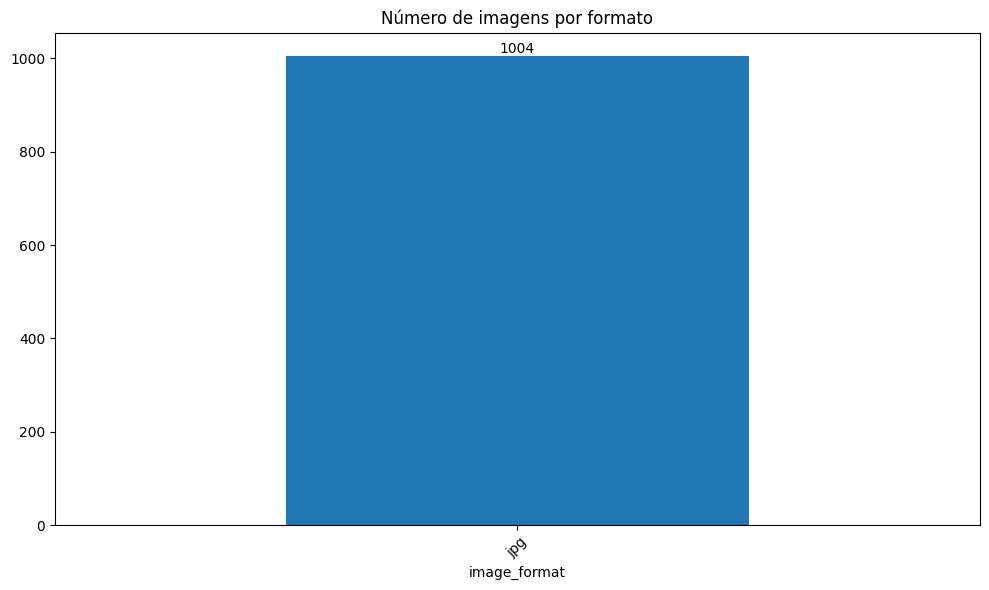


 Status de integridade:
  Total de imagens: 2098
  Imagens válidas: 1004
  Imagens corrompidas: 0
  Taxa de sucesso: 47.9%


In [89]:
print(f"\n MÓDULO 4: Verificação da integridade dos arquivos")
print("=" * 55)

def verificar_integridade():
    """Analisa a integridade dos arquivos, baseado no modelo do professor"""

    if df is None or len(df) == 0:
        print(" DataFrame não está disponível")
        return

    print(" Informações estatísticas das dimensões das imagens:")

    # Estatísticas das dimensões
    stats_cols = ['width', 'height', 'channels', 'num_classes']
    stats_df = df[stats_cols].describe().loc[['mean', 'std', 'min', 'max']]
    print(stats_df)

    print(f"\n Quantidade de imagens por formato:")

    # Gráfico de formatos
    plt.figure(figsize=(10, 6))
    ax = df['image_format'].value_counts().plot(kind='bar', title='Número de imagens por formato')

    for p in ax.patches:
        ax.annotate(str(int(p.get_height())),
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Informações sobre corrupção
    print(f"\n Status de integridade:")
    print(f"  Total de imagens: {len(df_completo) if df_completo is not None else 'N/A'}")
    print(f"  Imagens válidas: {len(df)}")
    print(f"  Imagens corrompidas: {df_completo['corrupted'].sum() if df_completo is not None else 'N/A'}")
    print(f"  Taxa de sucesso: {len(df)/len(df_completo)*100:.1f}%" if df_completo is not None else "N/A")

# Executar verificação
verificar_integridade()



# MÓDULO 5: VERIFICAR CONSISTÊNCIA DOS METADADOS  


 MÓDULO 5: Verificação da consistência dos metadados
 Distribuição das dimensões (Altura vs Largura):


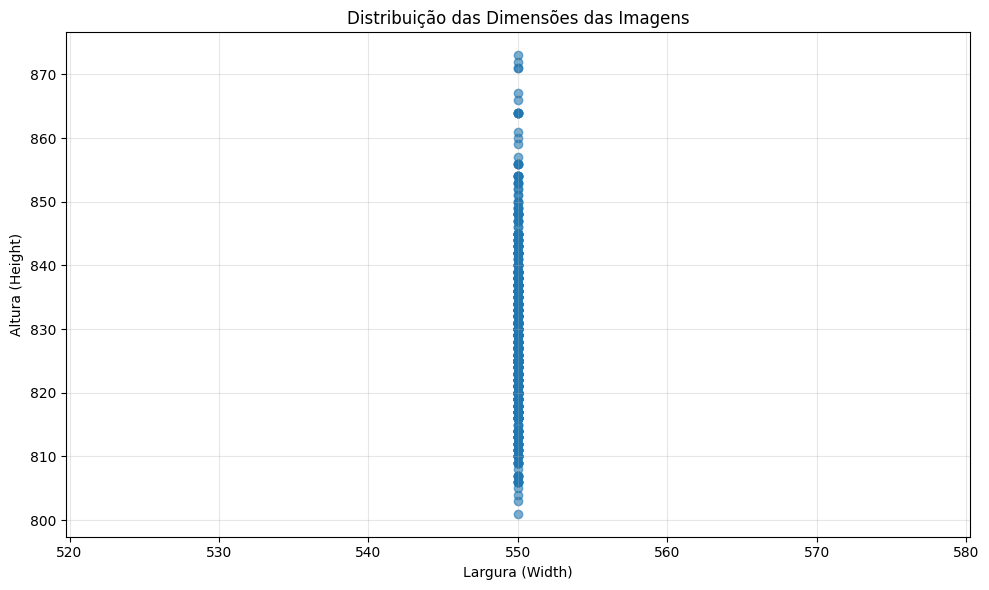


 Quantidade de informações nulas por coluna:
  Nenhum valor nulo encontrado!

 Estatísticas das classes por imagem:
  Média de classes por imagem: 7.24
  Mediana: 7.0
  Mínimo: 0
  Máximo: 13


In [90]:
print(f"\n MÓDULO 5: Verificação da consistência dos metadados")
print("=" * 60)

def verificar_consistencia():
    """Verifica consistência dos metadados"""

    print(" Distribuição das dimensões (Altura vs Largura):")

    plt.figure(figsize=(10, 6))
    plt.scatter(df['width'], df['height'], alpha=0.6)
    plt.xlabel('Largura (Width)')
    plt.ylabel('Altura (Height)')
    plt.title('Distribuição das Dimensões das Imagens')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\n Quantidade de informações nulas por coluna:")
    null_counts = df.isnull().sum()
    for col, count in null_counts.items():
        if count > 0:
            print(f"  {col}: {count} valores nulos")

    if null_counts.sum() == 0:
        print("  Nenhum valor nulo encontrado!")

    print(f"\n Estatísticas das classes por imagem:")
    print(f"  Média de classes por imagem: {df['num_classes'].mean():.2f}")
    print(f"  Mediana: {df['num_classes'].median():.1f}")
    print(f"  Mínimo: {df['num_classes'].min()}")
    print(f"  Máximo: {df['num_classes'].max()}")

# Executar verificação
verificar_consistencia()

# MÓDULO 6: ANALISAR QUALIDADE DAS IMAGENS

🔧 EXECUTANDO ANÁLISE CORRIGIDA...
🏥 Status de corrupção das imagens:
  Total de imagens corrompidas: 0
  Total de imagens: 2098
  Taxa de corrupção: 0.00%


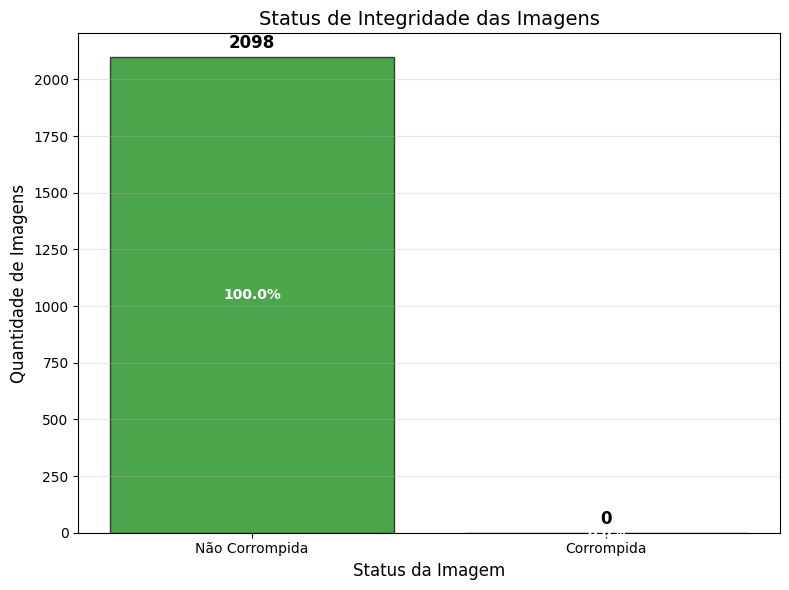


📸 Análise de dimensões:


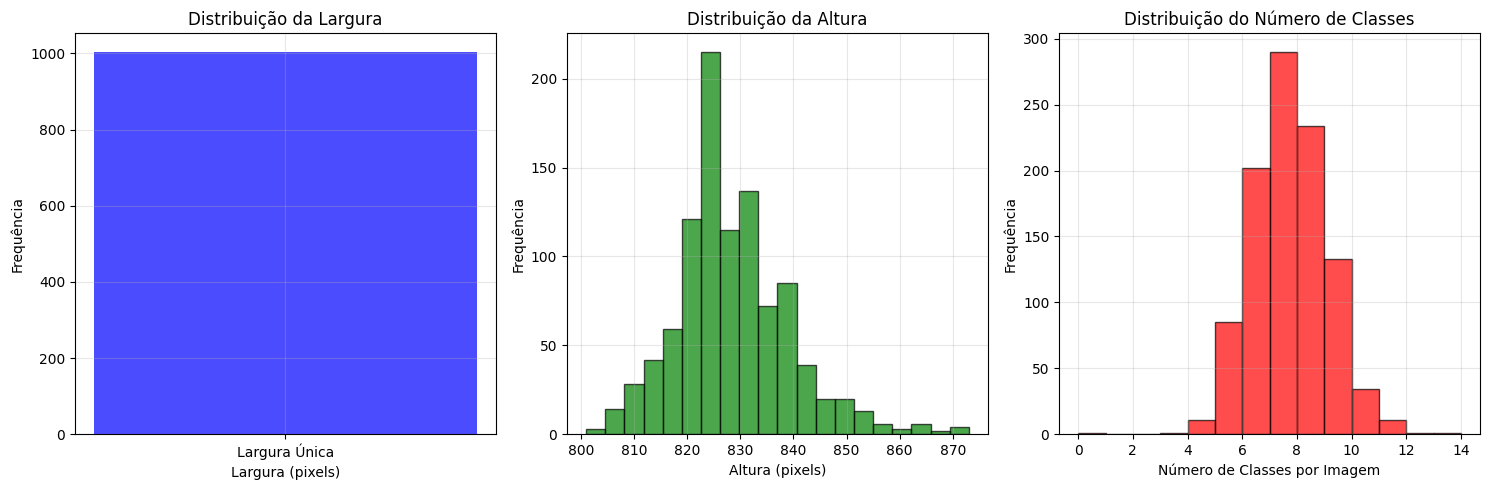

In [99]:
def analisar_qualidade_corrigido():
    """Versão corrigida da análise de qualidade"""

    print(" Status de corrupção das imagens:")

    if df_completo is not None:
        # Total de imagens corrompidas
        corrupted_count = df_completo['corrupted'].sum()
        total_count = len(df_completo)

        print(f"  Total de imagens corrompidas: {corrupted_count}")
        print(f"  Total de imagens: {total_count}")
        print(f"  Taxa de corrupção: {corrupted_count/total_count*100:.2f}%")

        # Gráfico de corrupção - VERSÃO CORRIGIDA
        plt.figure(figsize=(8, 6))

        # Contar valores manualmente
        nao_corrompidas = (df_completo['corrupted'] == False).sum()
        corrompidas = (df_completo['corrupted'] == True).sum()

        # Dados para o gráfico
        categorias = ['Não Corrompida', 'Corrompida']
        valores = [nao_corrompidas, corrompidas]
        cores = ['green', 'red']

        # Criar gráfico de barras
        bars = plt.bar(categorias, valores, color=cores, alpha=0.7, edgecolor='black')
        plt.title('Status de Integridade das Imagens', fontsize=14)
        plt.xlabel('Status da Imagem', fontsize=12)
        plt.ylabel('Quantidade de Imagens', fontsize=12)

        # Adicionar valores nas barras
        for bar, valor in zip(bars, valores):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + max(valores)*0.01,
                    f'{valor}', ha='center', va='bottom', fontsize=12, fontweight='bold')

        # Adicionar percentuais
        for bar, valor in zip(bars, valores):
            pct = valor/total_count*100
            plt.text(bar.get_x() + bar.get_width()/2., valor/2,
                    f'{pct:.1f}%', ha='center', va='center',
                    fontsize=10, color='white', fontweight='bold')

        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

    print(f"\n Análise de dimensões:")

    # Verificar se há dados válidos para plotar
    if df is not None and len(df) > 0:
        # Filtrar dados válidos
        dados_validos = df.dropna(subset=['width', 'height', 'num_classes'])

        if len(dados_validos) > 0:
            # Distribuição de dimensões
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Largura
            if dados_validos['width'].nunique() > 1:
                axes[0].hist(dados_validos['width'], bins=min(20, dados_validos['width'].nunique()),
                           alpha=0.7, color='blue', edgecolor='black')
            else:
                axes[0].bar(['Largura Única'], [len(dados_validos)], color='blue', alpha=0.7)
            axes[0].set_title('Distribuição da Largura')
            axes[0].set_xlabel('Largura (pixels)')
            axes[0].set_ylabel('Frequência')
            axes[0].grid(alpha=0.3)

            # Altura
            if dados_validos['height'].nunique() > 1:
                axes[1].hist(dados_validos['height'], bins=min(20, dados_validos['height'].nunique()),
                           alpha=0.7, color='green', edgecolor='black')
            else:
                axes[1].bar(['Altura Única'], [len(dados_validos)], color='green', alpha=0.7)
            axes[1].set_title('Distribuição da Altura')
            axes[1].set_xlabel('Altura (pixels)')
            axes[1].set_ylabel('Frequência')
            axes[1].grid(alpha=0.3)

            # Número de classes
            max_classes = dados_validos['num_classes'].max()
            if max_classes > 0:
                bins = range(dados_validos['num_classes'].min(), max_classes + 2)
                axes[2].hist(dados_validos['num_classes'], bins=bins,
                           alpha=0.7, color='red', edgecolor='black')
            else:
                axes[2].bar(['Sem Classes'], [len(dados_validos)], color='red', alpha=0.7)
            axes[2].set_title('Distribuição do Número de Classes')
            axes[2].set_xlabel('Número de Classes por Imagem')
            axes[2].set_ylabel('Frequência')
            axes[2].grid(alpha=0.3)

            plt.tight_layout()
            plt.show()
        else:
            print(" Não há dados válidos suficientes para análise de dimensões")
    else:
        print(" DataFrame principal não está disponível")

# Executar versão corrigida
print("🔧 EXECUTANDO ANÁLISE CORRIGIDA...")
analisar_qualidade_corrigido()

# MÓDULO 7: VERIFICAR DISTRIBUIÇÃO DAS CLASSES


🏷️ MÓDULO 7: Verificação da distribuição das classes
📊 Estatísticas das classes:
  Total de instâncias: 7269
  Classes únicas: 54
  Imagens com classes: 1004

🔝 Top 15 classes mais comuns:
   1. skin            1003 ( 13.8%)
   2. hair             960 ( 13.2%)
   3. shoes            775 ( 10.7%)
   4. bag              443 (  6.1%)
   5. pants            302 (  4.2%)
   6. sunglasses       293 (  4.0%)
   7. dress            271 (  3.7%)
   8. purse            234 (  3.2%)
   9. coat             232 (  3.2%)
  10. accessories      223 (  3.1%)
  11. blouse           220 (  3.0%)
  12. belt             195 (  2.7%)
  13. shirt            182 (  2.5%)
  14. skirt            167 (  2.3%)
  15. jeans            155 (  2.1%)


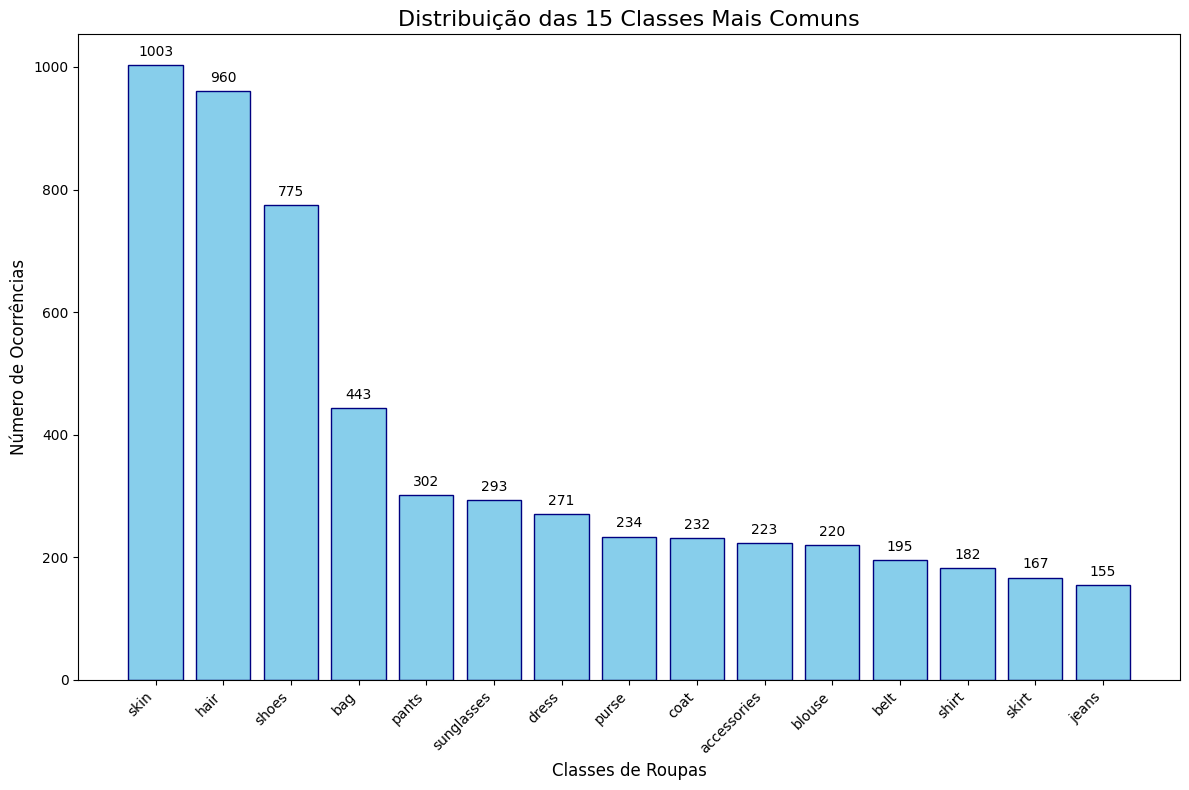

In [93]:
print(f"\n🏷️ MÓDULO 7: Verificação da distribuição das classes")
print("=" * 55)

def analisar_distribuicao_classes():
    """Analisa distribuição das classes de roupas"""

    # Coletar todas as classes
    todas_classes = []
    for classes_list in df['classes']:
        todas_classes.extend(classes_list)

    contador_classes = Counter(todas_classes)

    print(f"📊 Estatísticas das classes:")
    print(f"  Total de instâncias: {len(todas_classes)}")
    print(f"  Classes únicas: {len(contador_classes)}")
    print(f"  Imagens com classes: {len(df)}")

    # Top 15 classes mais comuns
    top_classes = contador_classes.most_common(15)

    print(f"\n🔝 Top 15 classes mais comuns:")
    for i, (classe, count) in enumerate(top_classes, 1):
        porcentagem = count/len(todas_classes)*100
        print(f"  {i:2d}. {classe:15} {count:4d} ({porcentagem:5.1f}%)")

    # Gráfico das classes principais
    plt.figure(figsize=(12, 8))
    classes_names = [item[0] for item in top_classes]
    classes_counts = [item[1] for item in top_classes]

    ax = plt.bar(range(len(classes_names)), classes_counts, color='skyblue', edgecolor='navy')
    plt.title('Distribuição das 15 Classes Mais Comuns', fontsize=16)
    plt.xlabel('Classes de Roupas', fontsize=12)
    plt.ylabel('Número de Ocorrências', fontsize=12)
    plt.xticks(range(len(classes_names)), classes_names, rotation=45, ha='right')

    # Adicionar valores nas barras
    for i, (bar, count) in enumerate(zip(ax, classes_counts)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                str(count), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    return contador_classes

# Executar análise
stats_classes = analisar_distribuicao_classes()

# MÓDULO 8: VERIFICAR DUPLICATAS

In [101]:

print(f"\n MÓDULO 8: Verificação de duplicatas")
print("=" * 40)

def verificar_duplicatas():
    """Verifica duplicatas usando hash perceptual, baseado no modelo do professor"""

    print(" Analisando duplicatas por hash perceptual...")

    # Filtrar apenas registros com hash válido
    df_com_hash = df[df['image_hash'].notna()].copy()

    # Quantidade de duplicatas
    duplicatas_count = df_com_hash['image_hash'].duplicated().sum()

    print(f"  Total de imagens analisadas: {len(df_com_hash)}")
    print(f"  Quantidade de imagens duplicadas: {duplicatas_count}")

    if duplicatas_count > 0:
        # DataFrame com duplicatas
        df_duplicated = df_com_hash[df_com_hash['image_hash'].duplicated(keep=False)].copy()

        print(f"\n Detalhes das imagens duplicadas:")
        print(df_duplicated[['image_id', 'image_hash', 'classes']].head(10))

        # Agrupar duplicatas
        duplicated_groups = {}
        for _, row in df_duplicated.iterrows():
            hash_val = row['image_hash']
            if hash_val not in duplicated_groups:
                duplicated_groups[hash_val] = []
            duplicated_groups[hash_val].append({
                'image_id': row['image_id'],
                'path': row['image_path_relative'],
                'classes': row['classes']
            })

        print(f"\n Grupos de duplicatas encontrados: {len(duplicated_groups)}")

        # Mostrar primeiro grupo como exemplo
        if duplicated_groups:
            first_hash = list(duplicated_groups.keys())[0]
            first_group = duplicated_groups[first_hash]

            print(f"\n📸 Exemplo de grupo duplicado (Hash: {first_hash}):")
            for item in first_group:
                print(f"  - ID: {item['image_id']}, Classes: {item['classes']}")

        # Análise de duplicatas por número de classes
        classes_counts = [len(row['classes']) for _, row in df_duplicated.iterrows()]

        plt.figure(figsize=(10, 6))
        plt.hist(classes_counts, bins=range(max(classes_counts)+2), alpha=0.7, color='orange')
        plt.title('Distribuição do Número de Classes nas Imagens Duplicadas')
        plt.xlabel('Número de Classes por Imagem Duplicada')
        plt.ylabel('Frequência')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return df_duplicated, duplicated_groups

    else:
        print(" Nenhuma duplicata encontrada!")
        return None, None

# Executar verificação
df_duplicatas, grupos_duplicatas = verificar_duplicatas()


 MÓDULO 8: Verificação de duplicatas
 Analisando duplicatas por hash perceptual...
  Total de imagens analisadas: 1004
  Quantidade de imagens duplicadas: 0
 Nenhuma duplicata encontrada!


# MÓDULO 9: VISUALIZAÇÃO DE EXEMPLOS


🖼️ MÓDULO 9: Visualização de exemplos
🎨 Visualizando 4 exemplos aleatórios do dataset:


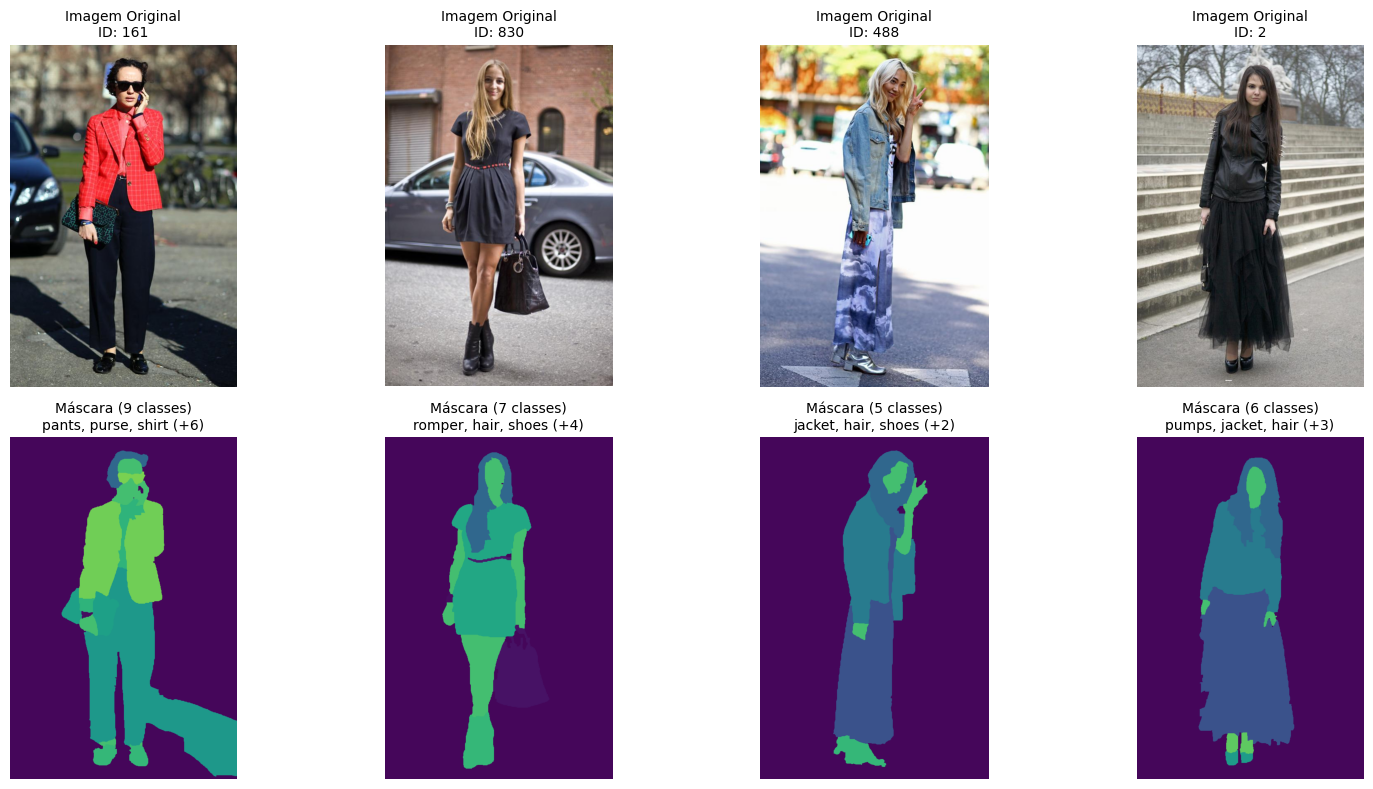

In [95]:
print(f"\n🖼️ MÓDULO 9: Visualização de exemplos")
print("=" * 40)

def visualizar_exemplos_dataset(num_exemplos=4):
    """Visualiza exemplos do dataset com suas máscaras"""

    print(f"🎨 Visualizando {num_exemplos} exemplos aleatórios do dataset:")

    # Selecionar exemplos aleatórios com pelo menos 2 classes
    df_com_classes = df[df['num_classes'] >= 2].copy()
    exemplos = df_com_classes.sample(n=min(num_exemplos, len(df_com_classes)))

    fig, axes = plt.subplots(2, num_exemplos, figsize=(4*num_exemplos, 8))

    for i, (_, row) in enumerate(exemplos.iterrows()):
        try:
            # Carregar imagem original
            img_original = cv2.imread(row['image_path_full'])
            img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

            # Carregar máscara
            mask = Image.open(row['label_path_full'])

            # Plotar imagem original
            axes[0, i].imshow(img_original)
            axes[0, i].set_title(f'Imagem Original\nID: {row["image_id"]}', fontsize=10)
            axes[0, i].axis('off')

            # Plotar máscara
            axes[1, i].imshow(mask)
            classes_texto = ', '.join(row['classes'][:3])  # Mostrar apenas 3 primeiras
            if len(row['classes']) > 3:
                classes_texto += f" (+{len(row['classes'])-3})"
            axes[1, i].set_title(f'Máscara ({len(row["classes"])} classes)\n{classes_texto}', fontsize=10)
            axes[1, i].axis('off')

        except Exception as e:
            axes[0, i].text(0.5, 0.5, f'Erro ao\ncarregar\nimagem',
                           ha='center', va='center', transform=axes[0, i].transAxes)
            axes[1, i].text(0.5, 0.5, f'Erro: {str(e)[:20]}...',
                           ha='center', va='center', transform=axes[1, i].transAxes)
            axes[0, i].axis('off')
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Executar visualização
visualizar_exemplos_dataset(4)


# MÓDULO 10: RESUMO FINAL E SALVAMENTO


 MÓDULO 10: Resumo final, visualizações e salvamento
 RESUMO FINAL DO DATASET CLOTHING CO-PARSING
 Dataset processado com sucesso!
   Total de imagens válidas: 1004
   Imagens corrompidas: 0
   Taxa de sucesso: 47.9%

 Estatísticas de classes:
   Classes únicas encontradas: 54
   Total de instâncias de classes: 7269
   Média de classes por imagem: 7.24

 Dimensões das imagens:
   Largura média: 550px (±0)
   Altura média: 828px (±11)
   Formato mais comum: JPG

 Dataset processado salvo em: ./clothing-coparsing-dataset/dataset_processado_completo.csv
 Dataset para ML salvo em: ./clothing-coparsing-dataset/dataset_para_ml.csv
 Gerando visualizações do dataset...


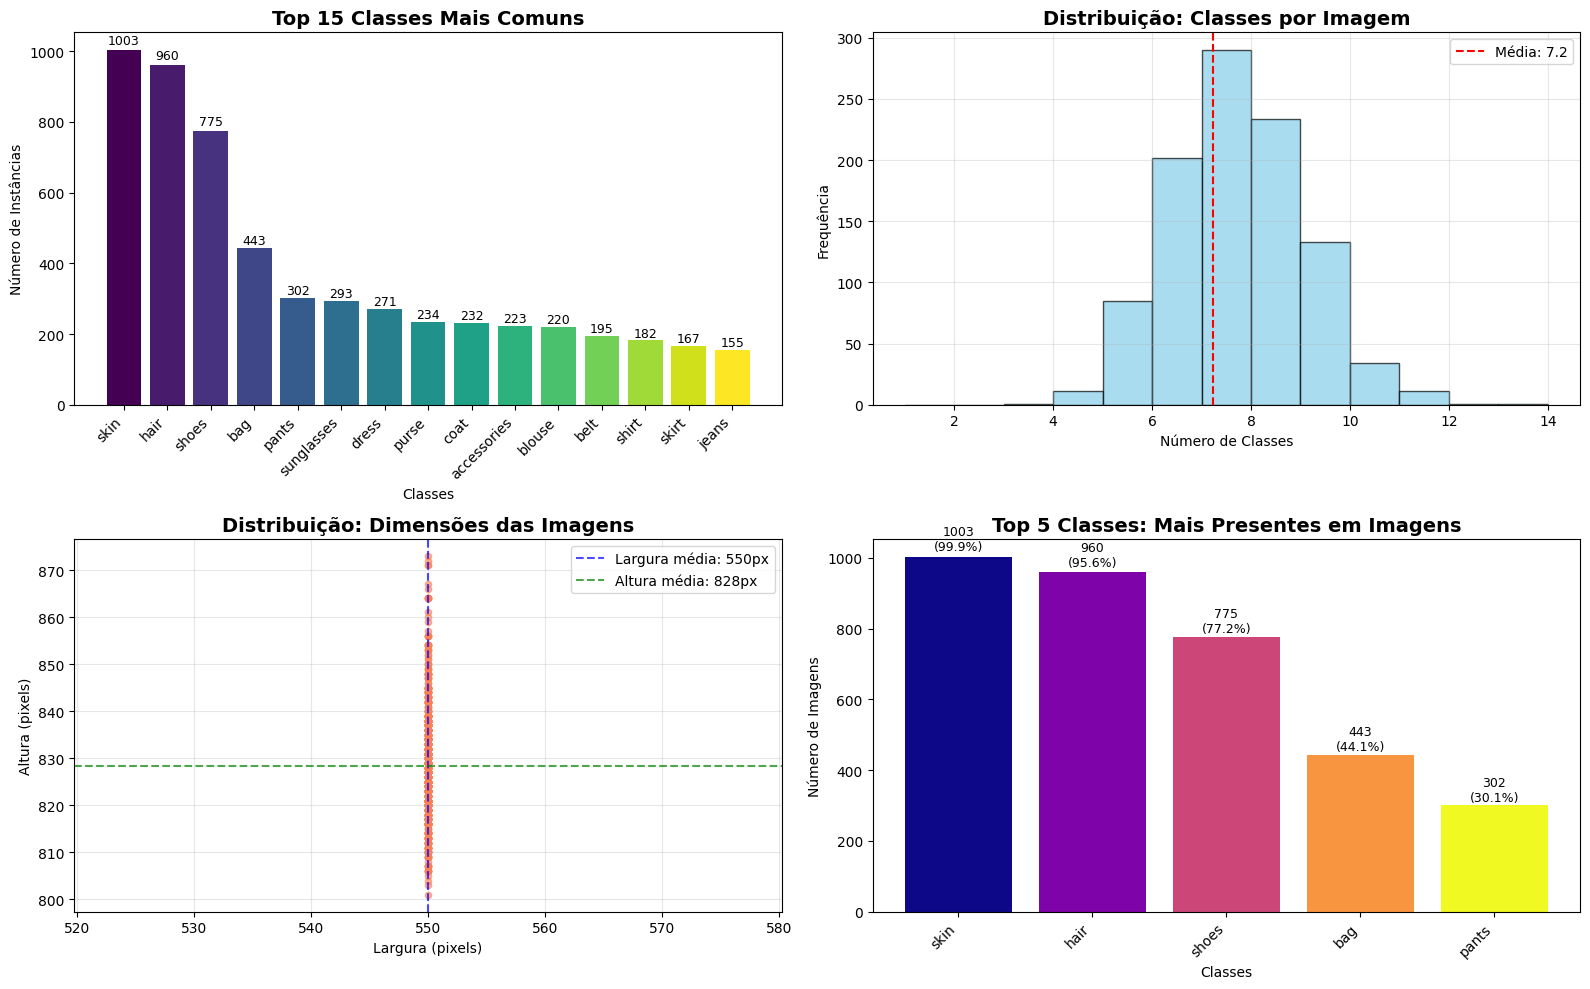

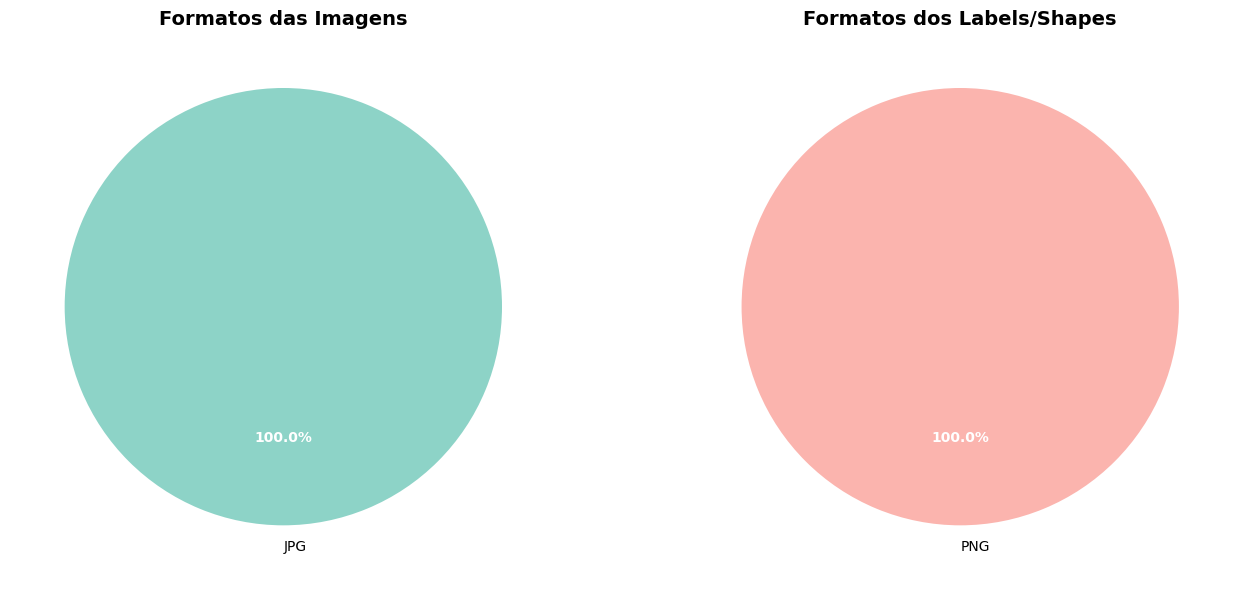

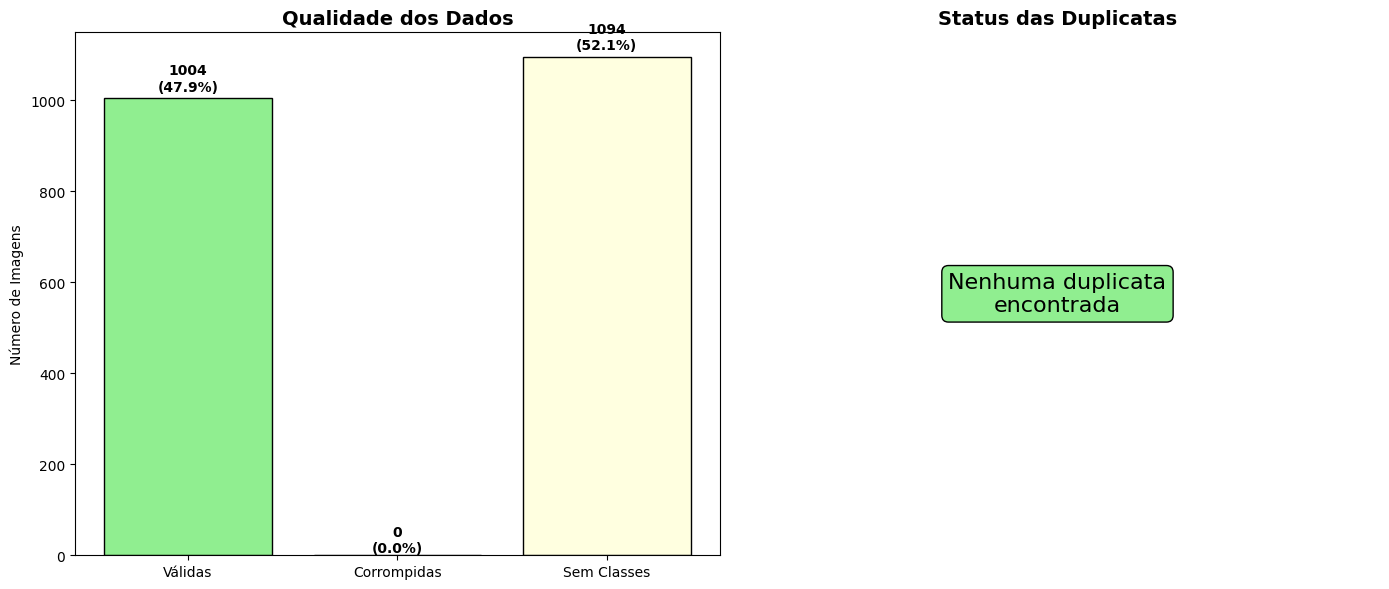

/tmp/ipython-input-3946331403.py:263: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_dims, labels=['Largura', 'Altura'])


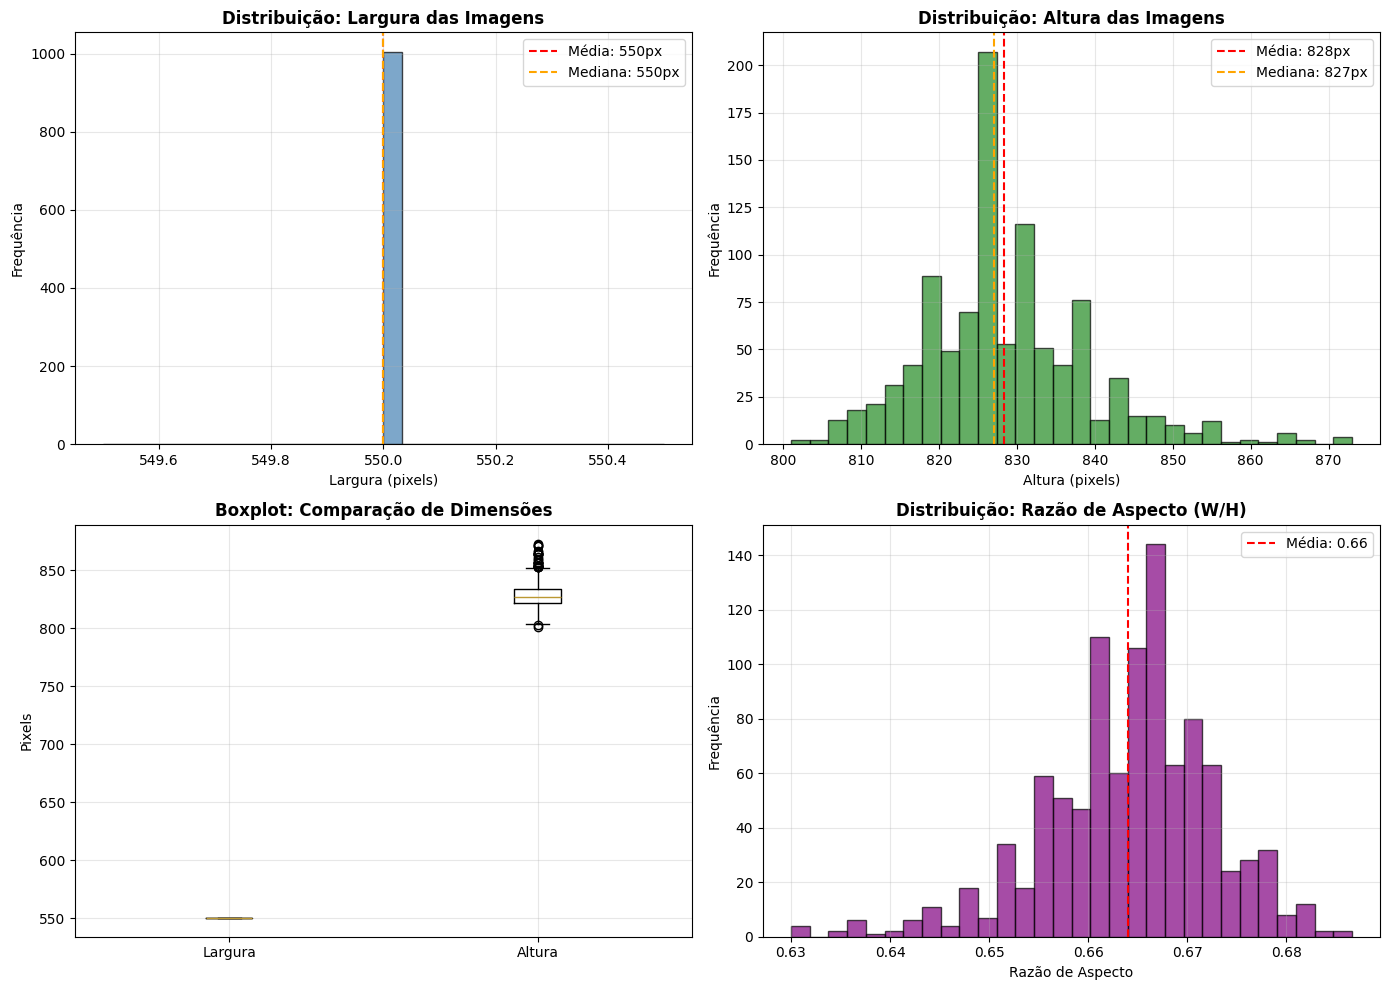

 Aviso: Coluna 'width' tem variância zero ou valores nulos - removida da correlação


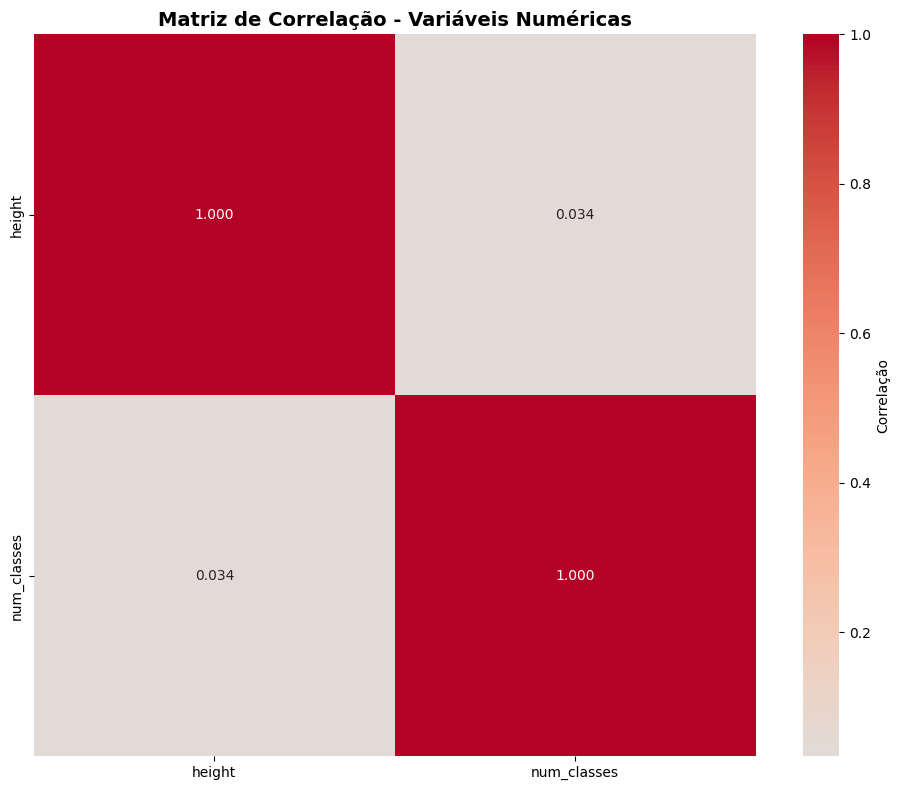

 Visualizações salvas em: ./clothing-coparsing-dataset/graficos_analise

 Gerando relatório detalhado...
 Relatório salvo em: ./clothing-coparsing-dataset/relatorio_detalhado.txt

 RESUMO DO RELATÓRIO:
RELATÓRIO DETALHADO - DATASET CLOTHING CO-PARSING

1. INFORMAÇÕES BÁSICAS
-------------------------
Dataset: Clothing Co-Parsing
Total de registros processados: 1004
Total de registros originais: 2098
Taxa de aproveitamento: 47.86%

2. ESTATÍSTICAS DAS IMAGENS
------------------------------
Dimensões médias: 550 x 828 pixels
Faixa de largura: 550 - 550 pixels
Faixa de altura: 801 - 873 pixels
Razão de aspecto média: 0.66
Formato principal: JPG

3. ESTATÍSTICAS DAS CLASSES
--------------------------------
Total de classes únicas: 54
Total de instâncias: 7269
Média por imagem: 7.24 classes
Classes por imagem (min-max): 0 - 13
...
[Relatório completo salvo em arquivo - 101 linhas total]

 Processamento completo! 
 - Arquivos CSV salvos
 - Relatório detalhado gerado
 - Visualizações criadas 

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
import os

# Configuração para gráficos
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print(f"\n MÓDULO 10: Resumo final, visualizações e salvamento")
print("=" * 55)

def criar_visualizacoes():
    """Cria visualizações gráficas do dataset"""

    print(" Gerando visualizações do dataset...")

    if df is None or len(df) == 0:
        print(" Erro: DataFrame vazio, não é possível criar visualizações")
        return False

    # Criar diretório para gráficos
    graficos_dir = os.path.join(BASE_DIR, "graficos_analise")
    os.makedirs(graficos_dir, exist_ok=True)

    # 1. Distribuição de classes (Top 15)
    plt.figure(figsize=(16, 10))
    todas_classes = []
    for classes_list in df['classes']:
        todas_classes.extend(classes_list)

    contador_classes = Counter(todas_classes)
    top_classes = contador_classes.most_common(15)

    classes_names = [classe for classe, _ in top_classes]
    classes_counts = [count for _, count in top_classes]

    plt.subplot(2, 2, 1)
    bars = plt.bar(range(len(classes_names)), classes_counts, color=plt.cm.viridis(np.linspace(0, 1, len(classes_names))))
    plt.title('Top 15 Classes Mais Comuns', fontsize=14, fontweight='bold')
    plt.xlabel('Classes')
    plt.ylabel('Número de Instâncias')
    plt.xticks(range(len(classes_names)), classes_names, rotation=45, ha='right')

    # Adicionar valores nas barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)

    # Novo gráfico: Top 5 classes com mais imagens (frequência em imagens, não instâncias)
    plt.subplot(2, 2, 4)

    # Calcular frequência de cada classe em número de imagens
    classes_por_imagem = {}
    for _, row in df.iterrows():
        for classe in row['classes']:
            if classe not in classes_por_imagem:
                classes_por_imagem[classe] = 0
            classes_por_imagem[classe] += 1

    # Top 5 classes que aparecem em mais imagens
    top_classes_imagens = sorted(classes_por_imagem.items(), key=lambda x: x[1], reverse=True)[:5]

    classes_img_names = [classe for classe, _ in top_classes_imagens]
    classes_img_counts = [count for _, count in top_classes_imagens]

    bars2 = plt.bar(range(len(classes_img_names)), classes_img_counts,
                    color=plt.cm.plasma(np.linspace(0, 1, len(classes_img_names))))
    plt.title('Top 5 Classes: Mais Presentes em Imagens', fontsize=14, fontweight='bold')
    plt.xlabel('Classes')
    plt.ylabel('Número de Imagens')
    plt.xticks(range(len(classes_img_names)), classes_img_names, rotation=45, ha='right')

    # Adicionar valores e percentuais nas barras
    total_imagens = len(df)
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        pct = height/total_imagens*100
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=9)

    # 2. Distribuição do número de classes por imagem
    plt.subplot(2, 2, 2)
    plt.hist(df['num_classes'], bins=range(1, df['num_classes'].max()+2),
             alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribuição: Classes por Imagem', fontsize=14, fontweight='bold')
    plt.xlabel('Número de Classes')
    plt.ylabel('Frequência')
    plt.grid(True, alpha=0.3)

    # Adicionar linha da média
    media_classes = df['num_classes'].mean()
    plt.axvline(media_classes, color='red', linestyle='--',
                label=f'Média: {media_classes:.1f}')
    plt.legend()

    # 3. Distribuição de dimensões das imagens
    plt.subplot(2, 2, 3)
    plt.scatter(df['width'], df['height'], alpha=0.6, s=20, color='coral')
    plt.title('Distribuição: Dimensões das Imagens', fontsize=14, fontweight='bold')
    plt.xlabel('Largura (pixels)')
    plt.ylabel('Altura (pixels)')
    plt.grid(True, alpha=0.3)

    # Adicionar linhas das médias
    plt.axvline(df['width'].mean(), color='blue', linestyle='--', alpha=0.7,
                label=f'Largura média: {df["width"].mean():.0f}px')
    plt.axhline(df['height'].mean(), color='green', linestyle='--', alpha=0.7,
                label=f'Altura média: {df["height"].mean():.0f}px')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(graficos_dir, '01_overview_dataset.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Gráfico para distribuição de formatos (imagens e labels)
    plt.figure(figsize=(14, 6))

    # Subplot 1: Formatos das imagens
    plt.subplot(1, 2, 1)
    formato_counts_img = df['image_format'].value_counts()
    colors_img = plt.cm.Set3(np.linspace(0, 1, len(formato_counts_img)))
    wedges, texts, autotexts = plt.pie(formato_counts_img.values,
                                      labels=[f'{fmt.upper()}' for fmt in formato_counts_img.index],
                                      autopct='%1.1f%%', colors=colors_img, startangle=90)
    plt.title('Formatos das Imagens', fontsize=14, fontweight='bold')

    # Melhorar aparência dos textos
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    # Subplot 2: Formatos dos labels/shapes (se existir coluna)
    plt.subplot(1, 2, 2)
    if 'label_format' in df.columns:
        formato_counts_label = df['label_format'].value_counts()
        colors_label = plt.cm.Pastel1(np.linspace(0, 1, len(formato_counts_label)))
        wedges2, texts2, autotexts2 = plt.pie(formato_counts_label.values,
                                             labels=[f'{fmt.upper()}' for fmt in formato_counts_label.index],
                                             autopct='%1.1f%%', colors=colors_label, startangle=90)
        plt.title('Formatos dos Labels/Shapes', fontsize=14, fontweight='bold')

        for autotext in autotexts2:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
    else:
        # Se não há coluna de formato dos labels, vamos extrair da extensão do arquivo
        if 'label_path_relative' in df.columns:
            df_temp = df.dropna(subset=['label_path_relative'])
            if len(df_temp) > 0:
                label_extensions = df_temp['label_path_relative'].apply(lambda x: x.split('.')[-1].lower() if pd.notna(x) else 'unknown')
                formato_counts_label = label_extensions.value_counts()
                colors_label = plt.cm.Pastel1(np.linspace(0, 1, len(formato_counts_label)))
                wedges2, texts2, autotexts2 = plt.pie(formato_counts_label.values,
                                                     labels=[f'{fmt.upper()}' for fmt in formato_counts_label.index],
                                                     autopct='%1.1f%%', colors=colors_label, startangle=90)
                plt.title('Formatos dos Labels/Shapes', fontsize=14, fontweight='bold')

                for autotext in autotexts2:
                    autotext.set_color('white')
                    autotext.set_fontweight('bold')
            else:
                plt.text(0.5, 0.5, 'Labels não\ndisponíveis', ha='center', va='center',
                        fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
                plt.title('Formatos dos Labels/Shapes', fontsize=14, fontweight='bold')
                plt.axis('off')
        else:
            plt.text(0.5, 0.5, 'Labels não\ndisponíveis', ha='center', va='center',
                    fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
            plt.title('Formatos dos Labels/Shapes', fontsize=14, fontweight='bold')
            plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(graficos_dir, '01b_formatos_completos.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

    # 5. Gráfico de qualidade dos dados
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    # Estatísticas de qualidade
    if df_completo is not None:
        corrupted = df_completo['corrupted'].sum()
        sem_classes = len(df_completo) - len(df)
        validas = len(df)

        categories = ['Válidas', 'Corrompidas', 'Sem Classes']
        values = [validas, corrupted, sem_classes]
        colors = ['lightgreen', 'lightcoral', 'lightyellow']

        bars = plt.bar(categories, values, color=colors, edgecolor='black')
        plt.title('Qualidade dos Dados', fontsize=14, fontweight='bold')
        plt.ylabel('Número de Imagens')

        # Adicionar percentuais
        total = sum(values)
        for i, (bar, value) in enumerate(zip(bars, values)):
            height = bar.get_height()
            pct = value/total*100 if total > 0 else 0
            plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{value}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

    plt.subplot(1, 2, 2)
    # Distribuição de duplicatas (se houver)
    if df_duplicatas is not None and len(df_duplicatas) > 0:
        unicas = len(df) - len(df_duplicatas)
        duplicadas = len(df_duplicatas)

        plt.pie([unicas, duplicadas], labels=['Únicas', 'Duplicadas'],
                autopct='%1.1f%%', colors=['lightblue', 'orange'], startangle=90)
        plt.title('Duplicatas no Dataset', fontsize=14, fontweight='bold')
    else:
        plt.text(0.5, 0.5, 'Nenhuma duplicata\nencontrada',
                ha='center', va='center', fontsize=16,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
        plt.title('Status das Duplicatas', fontsize=14, fontweight='bold')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(graficos_dir, '02_qualidade_dados.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

    # 6. Análise detalhada de dimensões
    plt.figure(figsize=(14, 10))

    # Histograma de larguras
    plt.subplot(2, 2, 1)
    plt.hist(df['width'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
    plt.title('Distribuição: Largura das Imagens', fontsize=12, fontweight='bold')
    plt.xlabel('Largura (pixels)')
    plt.ylabel('Frequência')
    plt.axvline(df['width'].mean(), color='red', linestyle='--',
                label=f'Média: {df["width"].mean():.0f}px')
    plt.axvline(df['width'].median(), color='orange', linestyle='--',
                label=f'Mediana: {df["width"].median():.0f}px')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Histograma de alturas
    plt.subplot(2, 2, 2)
    plt.hist(df['height'], bins=30, alpha=0.7, color='forestgreen', edgecolor='black')
    plt.title('Distribuição: Altura das Imagens', fontsize=12, fontweight='bold')
    plt.xlabel('Altura (pixels)')
    plt.ylabel('Frequência')
    plt.axvline(df['height'].mean(), color='red', linestyle='--',
                label=f'Média: {df["height"].mean():.0f}px')
    plt.axvline(df['height'].median(), color='orange', linestyle='--',
                label=f'Mediana: {df["height"].median():.0f}px')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Boxplot comparativo
    plt.subplot(2, 2, 3)
    data_dims = [df['width'], df['height']]
    plt.boxplot(data_dims, labels=['Largura', 'Altura'])
    plt.title('Boxplot: Comparação de Dimensões', fontsize=12, fontweight='bold')
    plt.ylabel('Pixels')
    plt.grid(True, alpha=0.3)

    # Razão aspecto
    plt.subplot(2, 2, 4)
    aspect_ratio = df['width'] / df['height']
    plt.hist(aspect_ratio, bins=30, alpha=0.7, color='purple', edgecolor='black')
    plt.title('Distribuição: Razão de Aspecto (W/H)', fontsize=12, fontweight='bold')
    plt.xlabel('Razão de Aspecto')
    plt.ylabel('Frequência')
    plt.axvline(aspect_ratio.mean(), color='red', linestyle='--',
                label=f'Média: {aspect_ratio.mean():.2f}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(graficos_dir, '03_analise_dimensoes.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

    # 7. Heatmap de correlações (com tratamento de erros)
    plt.figure(figsize=(10, 8))

    try:
        # Criar matriz de correlação com variáveis numéricas
        numeric_cols = ['width', 'height', 'num_classes']

        # Verificar se as colunas existem e têm variância
        available_cols = []
        for col in numeric_cols:
            if col in df.columns:
                if df[col].std() > 0 and not df[col].isnull().all():  # Verificar se há variância
                    available_cols.append(col)
                else:
                    print(f" Aviso: Coluna '{col}' tem variância zero ou valores nulos - removida da correlação")

        if len(available_cols) >= 2:
            # Calcular correlação apenas com colunas válidas
            corr_data = df[available_cols].copy()

            # Remover linhas com valores NaN
            corr_data = corr_data.dropna()

            if len(corr_data) > 1:
                corr_matrix = corr_data.corr()

                # Verificar se a matriz tem valores válidos
                if not corr_matrix.isnull().all().all():
                    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                                square=True, fmt='.3f', cbar_kws={'label': 'Correlação'},
                                xticklabels=True, yticklabels=True)
                    plt.title('Matriz de Correlação - Variáveis Numéricas', fontsize=14, fontweight='bold')
                else:
                    plt.text(0.5, 0.5, 'Dados insuficientes\npara correlação', ha='center', va='center',
                            fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))
                    plt.title('Matriz de Correlação - Dados Insuficientes', fontsize=14, fontweight='bold')
                    plt.axis('off')
            else:
                plt.text(0.5, 0.5, 'Dados insuficientes\npara correlação\n(muito poucos registros)',
                        ha='center', va='center', fontsize=16,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))
                plt.title('Matriz de Correlação - Dados Insuficientes', fontsize=14, fontweight='bold')
                plt.axis('off')
        else:
            plt.text(0.5, 0.5, f'Variáveis insuficientes\npara correlação\n(apenas {len(available_cols)} válidas)',
                    ha='center', va='center', fontsize=16,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))
            plt.title('Matriz de Correlação - Variáveis Insuficientes', fontsize=14, fontweight='bold')
            plt.axis('off')

    except Exception as e:
        print(f" Erro ao calcular correlações: {e}")
        plt.text(0.5, 0.5, f'Erro ao calcular\ncorrelações:\n{str(e)[:50]}...',
                ha='center', va='center', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
        plt.title('Matriz de Correlação - Erro', fontsize=14, fontweight='bold')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(graficos_dir, '04_correlacoes.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

    print(f" Visualizações salvas em: {graficos_dir}")
    return True

def gerar_resumo_final():
    """Gera resumo final do dataset processado"""

    print(" RESUMO FINAL DO DATASET CLOTHING CO-PARSING")
    print("=" * 55)

    if df is not None and len(df) > 0:
        # Estatísticas gerais
        print(f" Dataset processado com sucesso!")
        print(f"   Total de imagens válidas: {len(df)}")
        print(f"   Imagens corrompidas: {df_completo['corrupted'].sum() if df_completo is not None else 'N/A'}")
        print(f"   Taxa de sucesso: {len(df)/len(df_completo)*100:.1f}%" if df_completo is not None else "N/A")

        # Estatísticas de classes
        todas_classes = []
        for classes_list in df['classes']:
            todas_classes.extend(classes_list)

        print(f"\n Estatísticas de classes:")
        print(f"   Classes únicas encontradas: {len(set(todas_classes))}")
        print(f"   Total de instâncias de classes: {len(todas_classes)}")
        print(f"   Média de classes por imagem: {len(todas_classes)/len(df):.2f}")

        # Estatísticas de dimensões
        print(f"\n Dimensões das imagens:")
        print(f"   Largura média: {df['width'].mean():.0f}px (±{df['width'].std():.0f})")
        print(f"   Altura média: {df['height'].mean():.0f}px (±{df['height'].std():.0f})")
        print(f"   Formato mais comum: {df['image_format'].mode()[0].upper()}")

        # Estatísticas de duplicatas
        if df_duplicatas is not None:
            print(f"\n Duplicatas:")
            print(f"   Imagens duplicadas encontradas: {len(df_duplicatas)}")
            print(f"   Taxa de duplicação: {len(df_duplicatas)/len(df)*100:.2f}%")

        # Salvar DataFrame processado
        output_path = os.path.join(BASE_DIR, "dataset_processado_completo.csv")
        df.to_csv(output_path, index=False)
        print(f"\n Dataset processado salvo em: {output_path}")

        # Salvar apenas caminhos e classes para uso em ML
        df_ml = df[['image_path_relative', 'label_path_relative', 'classes', 'num_classes', 'width', 'height']].copy()
        ml_path = os.path.join(BASE_DIR, "dataset_para_ml.csv")
        df_ml.to_csv(ml_path, index=False)
        print(f" Dataset para ML salvo em: {ml_path}")

        # Gerar visualizações
        criar_visualizacoes()

        return True
    else:
        print(" Erro: DataFrame não foi criado corretamente")
        return False

def criar_relatorio_detalhado():
    """Cria um relatório detalhado em texto"""

    print(f"\n Gerando relatório detalhado...")

    relatorio = []
    relatorio.append("="*60)
    relatorio.append("RELATÓRIO DETALHADO - DATASET CLOTHING CO-PARSING")
    relatorio.append("="*60)
    relatorio.append("")

    # Informações básicas
    relatorio.append("1. INFORMAÇÕES BÁSICAS")
    relatorio.append("-" * 25)
    relatorio.append(f"Dataset: Clothing Co-Parsing")
    relatorio.append(f"Total de registros processados: {len(df) if df is not None else 0}")
    relatorio.append(f"Total de registros originais: {len(df_completo) if df_completo is not None else 0}")
    relatorio.append(f"Taxa de aproveitamento: {len(df)/len(df_completo)*100:.2f}%" if df_completo is not None and len(df_completo) > 0 else "N/A")
    relatorio.append("")

    if df is not None and len(df) > 0:
        # Estatísticas de imagens
        relatorio.append("2. ESTATÍSTICAS DAS IMAGENS")
        relatorio.append("-" * 30)
        relatorio.append(f"Dimensões médias: {df['width'].mean():.0f} x {df['height'].mean():.0f} pixels")
        relatorio.append(f"Faixa de largura: {df['width'].min()} - {df['width'].max()} pixels")
        relatorio.append(f"Faixa de altura: {df['height'].min()} - {df['height'].max()} pixels")
        relatorio.append(f"Razão de aspecto média: {(df['width']/df['height']).mean():.2f}")
        relatorio.append(f"Formato principal: {df['image_format'].mode()[0].upper()}")
        relatorio.append("")

        # Estatísticas de classes
        todas_classes = []
        for classes_list in df['classes']:
            todas_classes.extend(classes_list)

        contador_classes = Counter(todas_classes)

        relatorio.append("3. ESTATÍSTICAS DAS CLASSES")
        relatorio.append("-" * 32)
        relatorio.append(f"Total de classes únicas: {len(contador_classes)}")
        relatorio.append(f"Total de instâncias: {len(todas_classes)}")
        relatorio.append(f"Média por imagem: {len(todas_classes)/len(df):.2f} classes")
        relatorio.append(f"Classes por imagem (min-max): {df['num_classes'].min()} - {df['num_classes'].max()}")
        relatorio.append("")

        # Top 15 classes por instâncias e Top 5 por presença em imagens
        relatorio.append("4. ANÁLISE DETALHADA DAS CLASSES")
        relatorio.append("-" * 40)
        relatorio.append("")
        relatorio.append("4.1 TOP 15 CLASSES POR NÚMERO DE INSTÂNCIAS")
        relatorio.append("-" * 45)
        for i, (classe, count) in enumerate(contador_classes.most_common(15), 1):
            porcentagem = count/len(todas_classes)*100
            relatorio.append(f"{i:2d}. {classe:20} {count:4d} instâncias ({porcentagem:5.1f}%)")
        relatorio.append("")

        # Calcular frequência por imagens
        classes_por_imagem = {}
        for _, row in df.iterrows():
            for classe in row['classes']:
                if classe not in classes_por_imagem:
                    classes_por_imagem[classe] = 0
                classes_por_imagem[classe] += 1

        top_classes_imagens = sorted(classes_por_imagem.items(), key=lambda x: x[1], reverse=True)[:5]

        relatorio.append("4.2 TOP 5 CLASSES POR PRESENÇA EM IMAGENS")
        relatorio.append("-" * 42)
        total_imagens = len(df)
        for i, (classe, count) in enumerate(top_classes_imagens, 1):
            porcentagem = count/total_imagens*100
            relatorio.append(f"{i}. {classe:20} {count:4d} imagens ({porcentagem:5.1f}%)")
        relatorio.append("")

        # Qualidade dos dados
        relatorio.append("5. QUALIDADE DOS DADOS")
        relatorio.append("-" * 25)
        relatorio.append(f"Imagens corrompidas: {df_completo['corrupted'].sum() if df_completo is not None else 0}")
        relatorio.append(f"Imagens sem classes: {len(df_completo) - len(df) if df_completo is not None else 0}")
        relatorio.append(f"Valores nulos: {df.isnull().sum().sum()}")

        if df_duplicatas is not None:
            relatorio.append(f"Duplicatas encontradas: {len(df_duplicatas)}")
        else:
            relatorio.append("Duplicatas encontradas: 0")
        relatorio.append("")

        # Distribuição de formatos (imagens e labels)
        relatorio.append("6. DISTRIBUIÇÃO DE FORMATOS")
        relatorio.append("-" * 32)
        relatorio.append("6.1 FORMATOS DAS IMAGENS:")
        for formato, count in df['image_format'].value_counts().items():
            porcentagem = count/len(df)*100
            relatorio.append(f"    {formato.upper():4}: {count:4d} ({porcentagem:5.1f}%)")

        relatorio.append("")
        relatorio.append("6.2 FORMATOS DOS LABELS/SHAPES:")

        # Verificar se há coluna de formato dos labels
        if 'label_format' in df.columns:
            for formato, count in df['label_format'].value_counts().items():
                porcentagem = count/len(df)*100
                relatorio.append(f"    {formato.upper():4}: {count:4d} ({porcentagem:5.1f}%)")
        elif 'label_path_relative' in df.columns:
            df_temp = df.dropna(subset=['label_path_relative'])
            if len(df_temp) > 0:
                label_extensions = df_temp['label_path_relative'].apply(lambda x: x.split('.')[-1].lower() if pd.notna(x) else 'unknown')
                for formato, count in label_extensions.value_counts().items():
                    porcentagem = count/len(df_temp)*100
                    relatorio.append(f"    {formato.upper():4}: {count:4d} ({porcentagem:5.1f}%)")
            else:
                relatorio.append("    Nenhum label disponível")
        else:
            relatorio.append("    Coluna de labels não encontrada")
        relatorio.append("")

        # Análise estatística avançada
        relatorio.append("7. ANÁLISE ESTATÍSTICA AVANÇADA")
        relatorio.append("-" * 38)
        relatorio.append(f"Largura - Média: {df['width'].mean():.1f}, Mediana: {df['width'].median():.1f}, Desvio: {df['width'].std():.1f}")
        relatorio.append(f"Altura - Média: {df['height'].mean():.1f}, Mediana: {df['height'].median():.1f}, Desvio: {df['height'].std():.1f}")
        relatorio.append(f"Classes - Média: {df['num_classes'].mean():.1f}, Mediana: {df['num_classes'].median():.1f}, Desvio: {df['num_classes'].std():.1f}")

        # Correlações com tratamento de erro
        try:
            # Verificar se as variáveis têm variância suficiente
            if df['width'].std() > 0 and df['height'].std() > 0:
                corr_w_h = df['width'].corr(df['height'])
                relatorio.append(f"Correlação Largura-Altura: {corr_w_h:.3f}")
            else:
                relatorio.append("Correlação Largura-Altura: N/A (variância insuficiente)")

            if df['width'].std() > 0 and df['num_classes'].std() > 0:
                corr_w_classes = df['width'].corr(df['num_classes'])
                relatorio.append(f"Correlação Largura-Classes: {corr_w_classes:.3f}")
            else:
                relatorio.append("Correlação Largura-Classes: N/A (variância insuficiente)")

            if df['height'].std() > 0 and df['num_classes'].std() > 0:
                corr_h_classes = df['height'].corr(df['num_classes'])
                relatorio.append(f"Correlação Altura-Classes: {corr_h_classes:.3f}")
            else:
                relatorio.append("Correlação Altura-Classes: N/A (variância insuficiente)")

        except Exception as e:
            relatorio.append(f"Erro no cálculo de correlações: {str(e)[:50]}...")

        relatorio.append("")

        # Recomendações aprimoradas
        relatorio.append("8. RECOMENDAÇÕES E INSIGHTS")
        relatorio.append("-" * 33)

        # Taxa de corrupção
        taxa_corrupcao = df_completo['corrupted'].sum()/len(df_completo)*100 if df_completo is not None else 0
        if taxa_corrupcao > 5:
            relatorio.append(f"  Alta taxa de corrupção ({taxa_corrupcao:.1f}%) - investigar qualidade")
        else:
            relatorio.append(f" Taxa de corrupção aceitável ({taxa_corrupcao:.1f}%)")

        # Distribuição de classes
        if len(contador_classes) > 30:
            relatorio.append(f"  Muitas classes ({len(contador_classes)}) - considerar agrupamento")
        else:
            relatorio.append(f" Número de classes gerenciável ({len(contador_classes)})")

        # Duplicatas
        if df_duplicatas is not None and len(df_duplicatas) > len(df)*0.1:
            relatorio.append(f"  Muitas duplicatas ({len(df_duplicatas)}) - considerar remoção")
        else:
            relatorio.append(" Poucas duplicatas encontradas")

        # Dimensões
        cv_width = df['width'].std() / df['width'].mean()
        cv_height = df['height'].std() / df['height'].mean()

        if cv_width > 0.3 or cv_height > 0.3:
            relatorio.append(f"  Grande variação nas dimensões (CV: {cv_width:.2f}, {cv_height:.2f})")
        else:
            relatorio.append(" Dimensões relativamente consistentes")

        # Razão de aspecto
        aspect_ratios = df['width'] / df['height']
        if aspect_ratios.std() > 0.5:
            relatorio.append("  Grande variação na razão de aspecto")
        else:
            relatorio.append(" Razão de aspecto consistente")

        relatorio.append("")
        relatorio.append("9. ARQUIVOS GERADOS")
        relatorio.append("-" * 20)
        relatorio.append(" - dataset_processado_completo.csv")
        relatorio.append(" - dataset_para_ml.csv")
        relatorio.append(" - relatorio_detalhado.txt")
        relatorio.append(" - graficos_analise/01_overview_dataset.png")
        relatorio.append(" - graficos_analise/01b_formatos_completos.png")
        relatorio.append(" - graficos_analise/02_qualidade_dados.png")
        relatorio.append(" - graficos_analise/03_analise_dimensoes.png")
        relatorio.append(" - graficos_analise/04_correlacoes.png")

    relatorio.append("")
    relatorio.append("="*60)
    relatorio.append("Fim do Relatório")
    relatorio.append("="*60)

    # Salvar relatório
    relatorio_path = os.path.join(BASE_DIR, "relatorio_detalhado.txt")
    with open(relatorio_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(relatorio))

    print(f" Relatório salvo em: {relatorio_path}")

    # Mostrar resumo na tela
    print(f"\n RESUMO DO RELATÓRIO:")
    for linha in relatorio[:25]:  # Mostrar primeiras 25 linhas
        print(linha)

    if len(relatorio) > 25:
        print("...")
        print(f"[Relatório completo salvo em arquivo - {len(relatorio)} linhas total]")

# Executar resumo final (agora inclui visualizações)
sucesso = gerar_resumo_final()

# Executar criação do relatório detalhado
if sucesso:
    criar_relatorio_detalhado()

print(f"\n Processamento completo! ")
print(f" - Arquivos CSV salvos")
print(f" - Relatório detalhado gerado")
print(f" - Visualizações criadas na pasta 'graficos_analise'")
print("=" * 55)

# MÓDULO DE MÉTRICAS AVANÇADAS PARA SEGMENTAÇÃO



 MÓDULO 11: Análise de Métricas Avançadas

 DataFrame encontrado com 1004 registros
 BASE_DIR: ./clothing-coparsing-dataset

 INICIANDO ANÁLISE DE MÉTRICAS AVANÇADAS
 Analisando todas as 1004 imagens do dataset

 Analisando 15 amostras do dataset...
--------------------------------------------------

 Processando: 0711.jpg
   perfect     : Dice=1.000, Fit=1.000, Size=1.000, Pos=1.000
   smaller     : Dice=1.000, Fit=1.000, Size=1.000, Pos=1.000
   larger      : Dice=1.000, Fit=1.000, Size=1.000, Pos=1.000
   shifted     : Dice=0.962, Fit=0.600, Size=0.797, Pos=0.835
   noisy       : Dice=0.995, Fit=0.568, Size=0.971, Pos=0.998
   fragmented  : Dice=0.000, Fit=0.000, Size=0.000, Pos=0.000
   wrong_shape : Dice=0.583, Fit=0.570, Size=0.070, Pos=0.995


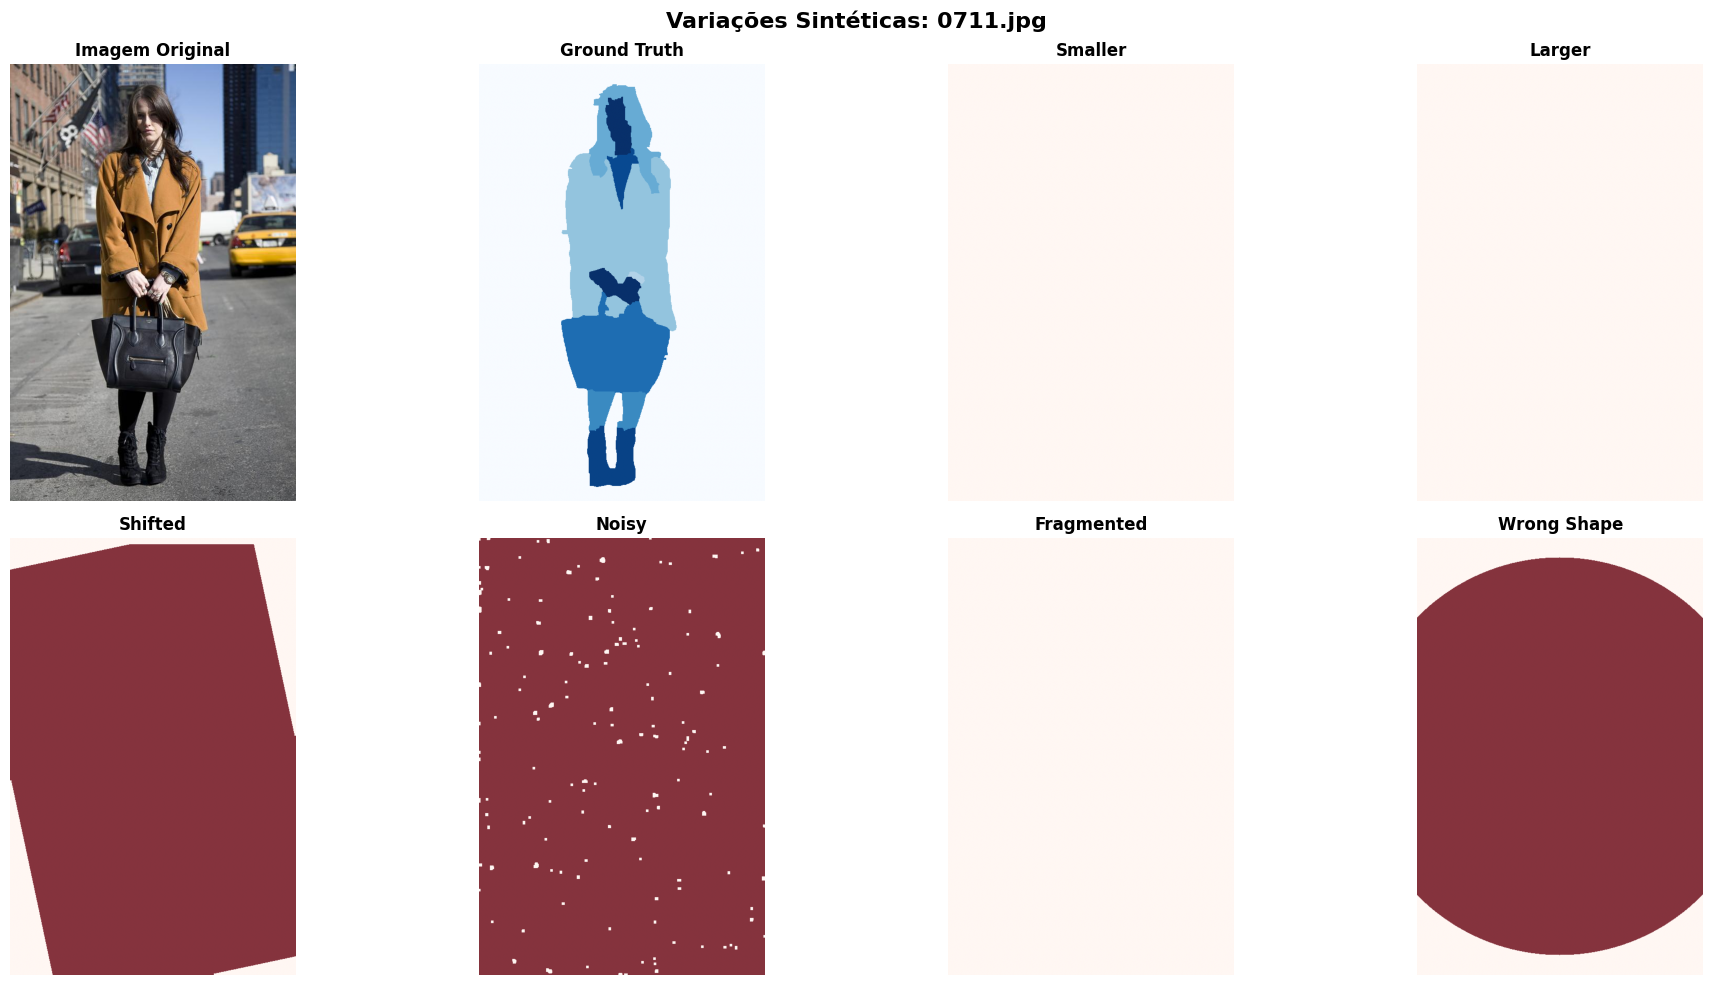


 Processando: 0947.jpg
   perfect     : Dice=1.000, Fit=1.000, Size=1.000, Pos=1.000
   smaller     : Dice=1.000, Fit=1.000, Size=1.000, Pos=1.000
   larger      : Dice=1.000, Fit=1.000, Size=1.000, Pos=1.000
   shifted     : Dice=0.937, Fit=0.592, Size=0.683, Pos=0.800
   noisy       : Dice=0.994, Fit=0.556, Size=0.966, Pos=0.998
   fragmented  : Dice=1.000, Fit=1.000, Size=1.000, Pos=1.000
   wrong_shape : Dice=0.912, Fit=0.534, Size=0.590, Pos=0.995

 Processando: 0285.jpg
   perfect     : Dice=1.000, Fit=1.000, Size=1.000, Pos=1.000
   smaller     : Dice=1.000, Fit=1.000, Size=1.000, Pos=1.000
   larger      : Dice=1.000, Fit=1.000, Size=1.000, Pos=1.000
   shifted     : Dice=0.926, Fit=0.591, Size=0.640, Pos=0.736
   noisy       : Dice=0.996, Fit=0.565, Size=0.974, Pos=0.999
   fragmented  : Dice=1.000, Fit=1.000, Size=1.000, Pos=1.000
   wrong_shape : Dice=0.909, Fit=0.535, Size=0.578, Pos=0.999

 Processando: 0739.jpg
   perfect     : Dice=1.000, Fit=1.000, Size=1.000, Pos=1.00

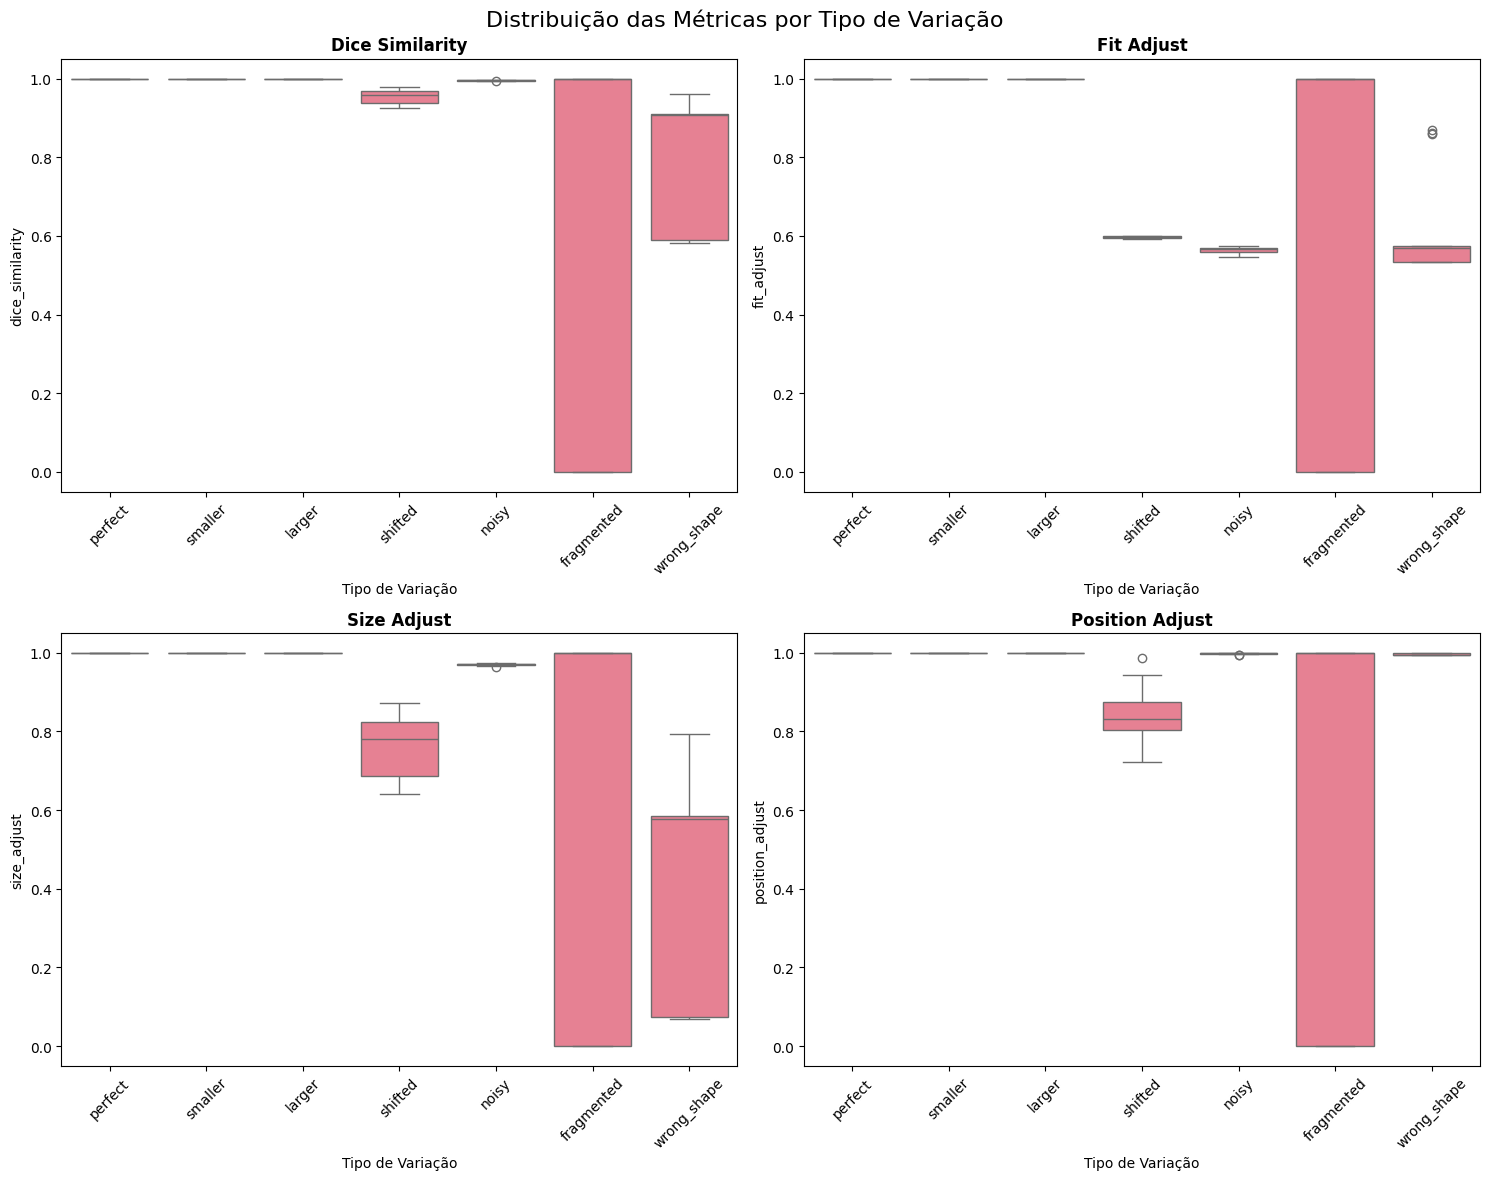

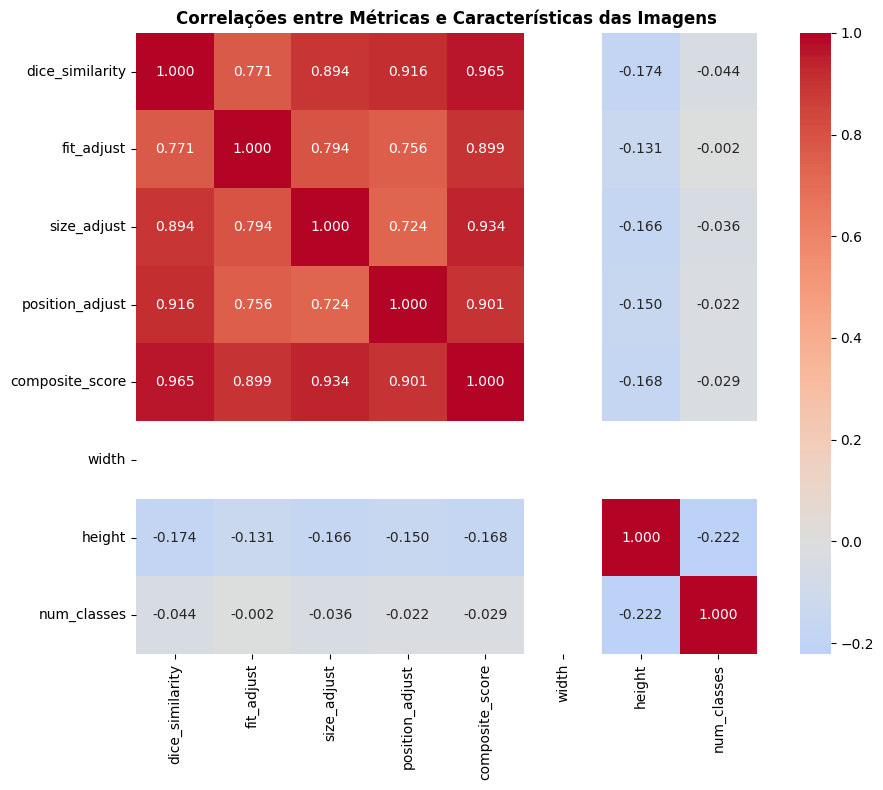

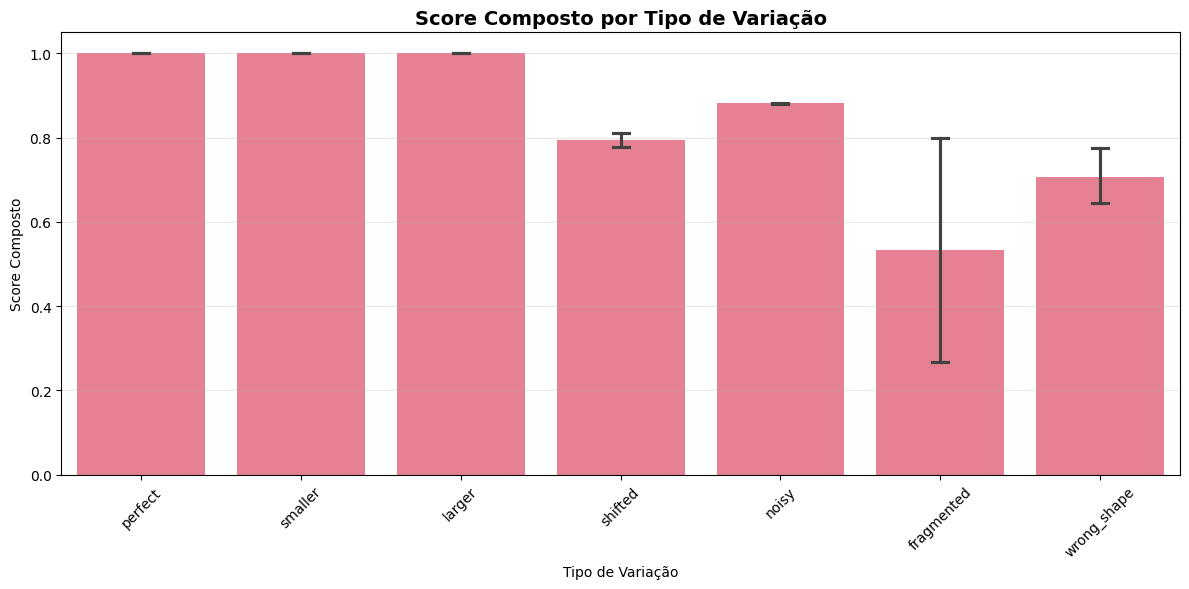


 Resultados salvos em: ./clothing-coparsing-dataset/advanced_metrics_analysis.csv

 MÓDULO 11 CARREGADO! 


In [122]:
"""
MÓDULO 11: ANÁLISE DE MÉTRICAS AVANÇADAS NO DATASET
===================================================

Calcula métricas avançadas de segmentação (classes passadas como referencia compute_fit_adjust, compute_size_adjust,
compute_position_adjust, compute_dice_similarity) usando as imagens reais do
DataFrame processado do dataset Clothing Co-Parsing.

Baseado no DataFrame 'df' já processado nos módulos anteriores.
"""

import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage
from scipy.spatial.distance import cdist
from skimage.measure import regionprops, label
from skimage.morphology import binary_erosion, binary_dilation
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print(f"\n MÓDULO 11: Análise de Métricas Avançadas")
print("=" * 50)

class DatasetMetricsAnalyzer:
    """
    Analisador de métricas avançadas para o dataset processado
    """

    def __init__(self, df, base_dir, sample_size=None, verbose=True):
        """
        Inicializa o analisador

        Args:
            df (pd.DataFrame): DataFrame processado do dataset
            base_dir (str): Diretório base do dataset
            sample_size (int): Número de amostras para analisar (None = todas)
            verbose (bool): Exibir informações detalhadas
        """
        self.df = df
        self.base_dir = base_dir
        self.verbose = verbose
        self.results = []

        # Selecionar amostra se especificado
        if sample_size and sample_size < len(df):
            self.df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
            if verbose:
                print(f" Analisando amostra de {sample_size} imagens de {len(df)} total")
        else:
            self.df_sample = df.copy()
            if verbose:
                print(f" Analisando todas as {len(df)} imagens do dataset")

    def load_masks(self, image_row):
        """
        Carrega imagem e máscara de segmentação

        Args:
            image_row: Linha do DataFrame com info da imagem

        Returns:
            tuple: (imagem, máscara_gt) ou (None, None) se erro
        """
        try:
            # Carregar imagem
            img_path = os.path.join(self.base_dir, image_row['image_path_relative'])
            if not os.path.exists(img_path):
                if self.verbose:
                    print(f" Imagem não encontrada: {img_path}")
                return None, None

            image = cv2.imread(img_path)
            if image is None:
                if self.verbose:
                    print(f" Erro ao carregar imagem: {img_path}")
                return None, None

            # Carregar máscara de segmentação
            mask_path = os.path.join(self.base_dir, image_row['label_path_relative'])
            if not os.path.exists(mask_path):
                if self.verbose:
                    print(f" Máscara não encontrada: {mask_path}")
                return None, None

            # Tentar diferentes formatos de máscara
            mask = None
            if mask_path.lower().endswith('.png'):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            elif mask_path.lower().endswith('.mat'):
                try:
                    from scipy.io import loadmat
                    mat_data = loadmat(mask_path)
                    # Procurar pela máscara no arquivo .mat
                    possible_keys = [k for k in mat_data.keys()
                                   if not k.startswith('__') and isinstance(mat_data[k], np.ndarray)]

                    for key in possible_keys:
                        if len(mat_data[key].shape) == 2 and mat_data[key].dtype != np.object:
                            mask = mat_data[key].astype(np.uint8)
                            # Se a máscara tem valores únicos além de 0 e 1, normalizar
                            if mask.max() > 1:
                                mask = ((mask > 0) * 255).astype(np.uint8)
                            break
                except ImportError:
                    if self.verbose:
                        print(f" scipy não disponível para carregar .mat: {mask_path}")
                    return None, None
                except Exception as e:
                    if self.verbose:
                        print(f" Erro ao carregar .mat {mask_path}: {e}")
                    return None, None

            if mask is None:
                if self.verbose:
                    print(f" Não foi possível carregar máscara: {mask_path}")
                return None, None

            # Redimensionar se necessário
            if image.shape[:2] != mask.shape[:2]:
                mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

            return image, mask

        except Exception as e:
            if self.verbose:
                print(f" Erro geral ao carregar {image_row.get('image_path_relative', 'unknown')}: {e}")
            return None, None

    def compute_dice_similarity(self, pred_mask, gt_mask, smooth=1e-6):
        """Calcula coeficiente Dice"""
        pred_flat = (pred_mask > 0).flatten().astype(float)
        gt_flat = (gt_mask > 0).flatten().astype(float)

        intersection = np.sum(pred_flat * gt_flat)
        union = np.sum(pred_flat) + np.sum(gt_flat)

        return (2.0 * intersection + smooth) / (union + smooth)

    def compute_fit_adjust(self, pred_mask, gt_mask, tolerance=0.1):
        """Calcula ajuste de forma"""
        pred_binary = (pred_mask > 0).astype(np.uint8)
        gt_binary = (gt_mask > 0).astype(np.uint8)

        # Encontrar contornos
        pred_contours, _ = cv2.findContours(pred_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        gt_contours, _ = cv2.findContours(gt_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not pred_contours or not gt_contours:
            return 0.0

        try:
            pred_contour = max(pred_contours, key=cv2.contourArea)
            gt_contour = max(gt_contours, key=cv2.contourArea)

            # Propriedades geométricas
            pred_area = cv2.contourArea(pred_contour)
            gt_area = cv2.contourArea(gt_contour)
            pred_perimeter = cv2.arcLength(pred_contour, True)
            gt_perimeter = cv2.arcLength(gt_contour, True)

            if pred_perimeter == 0 or gt_perimeter == 0:
                return 0.0

            # Compacidade
            pred_compactness = 4 * np.pi * pred_area / (pred_perimeter ** 2)
            gt_compactness = 4 * np.pi * gt_area / (gt_perimeter ** 2)

            compactness_score = 1 - abs(pred_compactness - gt_compactness)
            compactness_score = max(0, compactness_score)

            # Distância entre contornos
            pred_points = pred_contour.reshape(-1, 2)
            gt_points = gt_contour.reshape(-1, 2)

            distances = cdist(pred_points, gt_points)
            mean_distance = np.mean(np.min(distances, axis=1))

            diagonal = np.sqrt(pred_mask.shape[0]**2 + pred_mask.shape[1]**2)
            normalized_distance = mean_distance / diagonal

            contour_score = max(0, 1 - normalized_distance / tolerance)

            return 0.6 * compactness_score + 0.4 * contour_score

        except:
            return 0.0

    def compute_size_adjust(self, pred_mask, gt_mask, penalty_factor=2.0):
        """Calcula ajuste de tamanho"""
        pred_area = np.sum(pred_mask > 0)
        gt_area = np.sum(gt_mask > 0)

        if gt_area == 0:
            return 1.0 if pred_area == 0 else 0.0

        area_ratio = pred_area / gt_area

        if area_ratio <= 1.0:
            size_score = area_ratio
        else:
            size_score = 1.0 / area_ratio

        # Penalização suave
        size_penalty = np.exp(-penalty_factor * abs(np.log(area_ratio + 1e-6)))

        return size_score * size_penalty

    def compute_position_adjust(self, pred_mask, gt_mask, distance_threshold=0.1):
        """Calcula ajuste de posição"""
        pred_binary = (pred_mask > 0).astype(np.uint8)
        gt_binary = (gt_mask > 0).astype(np.uint8)

        pred_labeled = label(pred_binary)
        gt_labeled = label(gt_binary)

        pred_regions = regionprops(pred_labeled)
        gt_regions = regionprops(gt_labeled)

        if not pred_regions or not gt_regions:
            return 0.0

        pred_centroids = np.array([region.centroid for region in pred_regions])
        gt_centroids = np.array([region.centroid for region in gt_regions])

        diagonal = np.sqrt(pred_mask.shape[0]**2 + pred_mask.shape[1]**2)
        distances = cdist(pred_centroids, gt_centroids) / diagonal

        position_scores = []
        min_len = min(len(pred_centroids), len(gt_centroids))

        for i in range(min_len):
            if i < len(pred_centroids) and i < len(gt_centroids):
                min_dist = np.min(distances[i, :]) if len(distances[i, :]) > 0 else 1.0
                score = max(0, 1 - min_dist / distance_threshold)
                position_scores.append(score)

        return np.mean(position_scores) if position_scores else 0.0

    def generate_synthetic_prediction(self, gt_mask, variation_type='perfect'):
        """
        Gera uma predição sintética baseada na máscara ground truth
        para simular diferentes cenários de segmentação com variações mais agressivas
        """
        if variation_type == 'perfect':
            return gt_mask.copy()

        elif variation_type == 'smaller':
            # Versão significativamente menor (erosão mais agressiva)
            kernel = np.ones((7,7), np.uint8)
            eroded = cv2.erode((gt_mask > 0).astype(np.uint8), kernel, iterations=3)
            # Remover pequenos componentes para simular segmentação incompleta
            labeled = label(eroded)
            regions = regionprops(labeled)
            if regions:
                # Manter apenas regiões maiores que 20% da original
                min_area = np.sum(gt_mask > 0) * 0.2
                for region in regions:
                    if region.area < min_area:
                        eroded[labeled == region.label] = 0
            return eroded * 255

        elif variation_type == 'larger':
            # Versão significativamente maior (dilatação + ruído)
            kernel = np.ones((9,9), np.uint8)
            dilated = cv2.dilate((gt_mask > 0).astype(np.uint8), kernel, iterations=4)
            # Adicionar regiões extras aleatórias
            noise_mask = np.random.rand(*gt_mask.shape) > 0.95
            noise_regions = ndimage.binary_dilation(noise_mask, iterations=3)
            final = np.logical_or(dilated, noise_regions).astype(np.uint8)
            return final * 255

        elif variation_type == 'shifted':
            # Versão com deslocamento significativo + rotação
            height, width = gt_mask.shape
            # Deslocamento maior
            shift_x = np.random.randint(-30, 30)
            shift_y = np.random.randint(-30, 30)
            # Rotação leve
            angle = np.random.randint(-15, 15)

            # Matriz de transformação
            center = (width//2, height//2)
            M_rotate = cv2.getRotationMatrix2D(center, angle, 1.0)
            M_translate = np.float32([[1, 0, shift_x], [0, 1, shift_y]])

            # Aplicar transformações
            rotated = cv2.warpAffine(gt_mask, M_rotate, (width, height))
            shifted = cv2.warpAffine(rotated, M_translate, (width, height))

            # Adicionar deformação para simular erro de forma
            binary = (shifted > 0).astype(np.uint8)
            kernel = np.ones((5,5), np.uint8)
            # Alternado entre erosão e dilatação para criar irregularidades
            deformed = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
            deformed = cv2.morphologyEx(deformed, cv2.MORPH_CLOSE, kernel, iterations=1)

            return deformed * 255

        elif variation_type == 'noisy':
            # Versão com ruído estrutural e buracos
            result = gt_mask.copy()
            binary = (result > 0).astype(np.uint8)

            # Criar buracos aleatórios (simular falsos negativos)
            holes = np.random.rand(*gt_mask.shape) > 0.85
            holes = ndimage.binary_dilation(holes, iterations=2)
            binary[holes] = 0

            # Adicionar regiões falsas (simular falsos positivos)
            false_regions = np.random.rand(*gt_mask.shape) > 0.92
            false_regions = ndimage.binary_dilation(false_regions, iterations=3)
            binary = np.logical_or(binary, false_regions).astype(np.uint8)

            # Suavizar bordas irregularmente
            kernel = np.ones((3,3), np.uint8)
            binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
            binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

            return binary * 255

        elif variation_type == 'fragmented':
            # Nova variação: segmentação fragmentada
            binary = (gt_mask > 0).astype(np.uint8)

            # Quebrar em pedaços menores
            kernel = np.ones((11,11), np.uint8)
            opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=3)

            # Remover alguns fragmentos aleatoriamente
            labeled = label(opened)
            regions = regionprops(labeled)
            for region in regions:
                if np.random.rand() > 0.7:  # Remove 30% dos fragmentos
                    opened[labeled == region.label] = 0

            return opened * 255

        elif variation_type == 'wrong_shape':
            # Nova variação: forma completamente errada
            binary = (gt_mask > 0).astype(np.uint8)

            # Encontrar centroide da máscara original
            moments = cv2.moments(binary)
            if moments['m00'] > 0:
                cx = int(moments['m10'] / moments['m00'])
                cy = int(moments['m01'] / moments['m00'])

                # Criar forma geométrica simples no lugar
                result = np.zeros_like(gt_mask)
                area_original = np.sum(binary)
                radius = int(np.sqrt(area_original / np.pi))

                # Escolher forma aleatória
                shape_type = np.random.choice(['circle', 'rectangle', 'ellipse'])

                if shape_type == 'circle':
                    cv2.circle(result, (cx, cy), radius, 255, -1)
                elif shape_type == 'rectangle':
                    cv2.rectangle(result, (cx-radius, cy-radius),
                                (cx+radius, cy+radius), 255, -1)
                else:  # ellipse
                    cv2.ellipse(result, (cx, cy), (radius, radius//2), 0, 0, 360, 255, -1)

                return result

        return gt_mask.copy()

    def analyze_sample_images(self, n_samples=10, show_visualizations=True):
        """
        Analisa amostras do dataset com diferentes variações sintéticas
        """
        print(f"\n Analisando {n_samples} amostras do dataset...")
        print("-" * 50)

        sample_indices = np.random.choice(len(self.df_sample),
                                        min(n_samples, len(self.df_sample)),
                                        replace=False)

        # Variações mais agressivas e realistas
        variation_types = ['perfect', 'smaller', 'larger', 'shifted', 'noisy', 'fragmented', 'wrong_shape']

        all_results = []
        successful_samples = 0

        for idx in sample_indices:
            row = self.df_sample.iloc[idx]
            image, gt_mask = self.load_masks(row)

            if image is None or gt_mask is None:
                continue

            # Verificar se a máscara não está vazia
            if np.sum(gt_mask > 0) < 100:  # Máscaras muito pequenas
                continue

            successful_samples += 1
            print(f"\n Processando: {os.path.basename(row['image_path_relative'])}")

            sample_results = []

            for var_type in variation_types:
                try:
                    pred_mask = self.generate_synthetic_prediction(gt_mask, var_type)

                    # Calcular métricas
                    metrics = {
                        'image_name': os.path.basename(row['image_path_relative']),
                        'variation_type': var_type,
                        'dice_similarity': self.compute_dice_similarity(pred_mask, gt_mask),
                        'fit_adjust': self.compute_fit_adjust(pred_mask, gt_mask),
                        'size_adjust': self.compute_size_adjust(pred_mask, gt_mask),
                        'position_adjust': self.compute_position_adjust(pred_mask, gt_mask),
                        'width': row['width'],
                        'height': row['height'],
                        'num_classes': row['num_classes'],
                        'classes': row['classes']
                    }

                    # Score composto
                    weights = {'dice_similarity': 0.3, 'fit_adjust': 0.25,
                              'size_adjust': 0.25, 'position_adjust': 0.2}
                    metrics['composite_score'] = sum(metrics[key] * weights[key] for key in weights if key in metrics)

                    all_results.append(metrics)
                    sample_results.append(metrics)

                except Exception as e:
                    if self.verbose:
                        print(f"   Erro em {var_type}: {e}")
                    continue

            # Mostrar resultados desta amostra
            if self.verbose and sample_results:
                for result in sample_results:
                    var_type = result['variation_type']
                    print(f"   {var_type:12}: Dice={result['dice_similarity']:.3f}, "
                          f"Fit={result['fit_adjust']:.3f}, "
                          f"Size={result['size_adjust']:.3f}, "
                          f"Pos={result['position_adjust']:.3f}")

            # Visualizar primeira amostra bem-sucedida
            if show_visualizations and successful_samples == 1:
                self.visualize_sample_analysis_extended(image, gt_mask, row['image_path_relative'])

        if successful_samples == 0:
            print(" Erro: Nenhuma amostra foi processada com sucesso!")
            return None

        # Criar DataFrame com resultados
        if all_results:
            results_df = pd.DataFrame(all_results)
            self.results_df = results_df
            print(f"\n Processamento concluído: {len(all_results)} medições de {successful_samples} imagens")
            return results_df
        else:
            print(" Erro: Nenhum resultado foi gerado!")
            return None

    def visualize_sample_analysis_extended(self, image, gt_mask, image_name):
        """Visualiza análise estendida de uma amostra com mais variações"""
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))

        # Imagem original e GT
        axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[0, 0].set_title('Imagem Original', fontweight='bold')
        axes[0, 0].axis('off')

        axes[0, 1].imshow(gt_mask, cmap='Blues')
        axes[0, 1].set_title('Ground Truth', fontweight='bold')
        axes[0, 1].axis('off')

        # Variações
        variations = ['smaller', 'larger', 'shifted', 'noisy', 'fragmented', 'wrong_shape']
        positions = [(0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3)]

        for i, var_type in enumerate(variations):
            pred = self.generate_synthetic_prediction(gt_mask, var_type)
            row, col = positions[i]

            axes[row, col].imshow(pred, cmap='Reds', alpha=0.8)
            axes[row, col].set_title(f'{var_type.replace("_", " ").title()}', fontweight='bold')
            axes[row, col].axis('off')

        plt.suptitle(f'Variações Sintéticas: {os.path.basename(image_name)}',
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def generate_comprehensive_report(self):
        """Gera relatório completo das análises"""
        if not hasattr(self, 'results_df'):
            print(" Execute analyze_sample_images() primeiro!")
            return

        print(f"\n RELATÓRIO COMPLETO DE MÉTRICAS AVANÇADAS")
        print("=" * 55)

        df_results = self.results_df

        # Estatísticas por tipo de variação
        print(f"\n1. PERFORMANCE POR TIPO DE VARIAÇÃO")
        print("-" * 40)

        metrics_cols = ['dice_similarity', 'fit_adjust', 'size_adjust', 'position_adjust', 'composite_score']

        for var_type in df_results['variation_type'].unique():
            var_data = df_results[df_results['variation_type'] == var_type]
            print(f"\n{var_type.upper()}:")
            for metric in metrics_cols:
                mean_val = var_data[metric].mean()
                std_val = var_data[metric].std()
                print(f"  {metric:17}: {mean_val:.3f} (±{std_val:.3f})")

        # Criar visualizações
        self.create_metrics_visualizations()

        return df_results

    def create_metrics_visualizations(self):
        """Cria visualizações das métricas"""
        if not hasattr(self, 'results_df'):
            return

        df_results = self.results_df

        # Gráfico 1: Boxplots por variação
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        metrics = ['dice_similarity', 'fit_adjust', 'size_adjust', 'position_adjust']
        titles = ['Dice Similarity', 'Fit Adjust', 'Size Adjust', 'Position Adjust']

        for i, (metric, title) in enumerate(zip(metrics, titles)):
            row, col = i // 2, i % 2

            sns.boxplot(data=df_results, x='variation_type', y=metric, ax=axes[row, col])
            axes[row, col].set_title(title, fontweight='bold')
            axes[row, col].set_xlabel('Tipo de Variação')
            axes[row, col].tick_params(axis='x', rotation=45)

        plt.suptitle('Distribuição das Métricas por Tipo de Variação', fontsize=16)
        plt.tight_layout()
        plt.show()

        # Gráfico 2: Heatmap de correlações
        plt.figure(figsize=(10, 8))

        numeric_cols = ['dice_similarity', 'fit_adjust', 'size_adjust', 'position_adjust',
                       'composite_score', 'width', 'height', 'num_classes']

        corr_matrix = df_results[numeric_cols].corr()

        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                    square=True, fmt='.3f')
        plt.title('Correlações entre Métricas e Características das Imagens', fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Gráfico 3: Score composto por variação
        plt.figure(figsize=(12, 6))

        sns.barplot(data=df_results, x='variation_type', y='composite_score',
                   ci=95, capsize=0.1)
        plt.title('Score Composto por Tipo de Variação', fontsize=14, fontweight='bold')
        plt.xlabel('Tipo de Variação')
        plt.ylabel('Score Composto')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

# Executar análise
def run_advanced_metrics_analysis(df, base_dir, n_samples=20):
    """
    Função principal para executar análise de métricas avançadas

    Args:
        df: DataFrame processado do dataset
        base_dir: Diretório base do dataset
        n_samples: Número de amostras para analisar
    """
    print(f"\n INICIANDO ANÁLISE DE MÉTRICAS AVANÇADAS")
    print("=" * 55)

    # Verificar se DataFrame existe e tem dados
    if df is None or len(df) == 0:
        print(" Erro: DataFrame não encontrado ou vazio!")
        print(" Execute os módulos anteriores primeiro.")
        return None

    # Verificar colunas necessárias
    required_cols = ['image_path_relative', 'label_path_relative', 'width', 'height', 'classes']
    missing_cols = [col for col in required_cols if col not in df.columns]

    if missing_cols:
        print(f" Erro: Colunas faltantes no DataFrame: {missing_cols}")
        return None

    # Criar analisador
    analyzer = DatasetMetricsAnalyzer(df, base_dir, verbose=True)

    # Executar análise
    results_df = analyzer.analyze_sample_images(n_samples=n_samples, show_visualizations=True)

    if results_df is not None and len(results_df) > 0:
        # Gerar relatório
        final_results = analyzer.generate_comprehensive_report()

        # Salvar resultados
        output_path = os.path.join(base_dir, "advanced_metrics_analysis.csv")
        results_df.to_csv(output_path, index=False)
        print(f"\n Resultados salvos em: {output_path}")

        return results_df
    else:
        print(" Nenhum resultado obtido. Verificar caminhos das imagens.")
        return None

# Executar se o DataFrame existir
if 'df' in globals() and 'BASE_DIR' in globals():
    print(f"\n DataFrame encontrado com {len(df)} registros")
    print(f" BASE_DIR: {BASE_DIR}")

    # Executar análise com amostra
    results = run_advanced_metrics_analysis(df, BASE_DIR, n_samples=15)

else:
    print(f"\n Aguardando variáveis 'df' e 'BASE_DIR' dos módulos anteriores...")
    print(f" Para executar manualmente:")
    print(f" results = run_advanced_metrics_analysis(df, BASE_DIR, n_samples=20)")

print(f"\n MÓDULO 11 CARREGADO! ")
print("=" * 50)

# MÓDULO 11: FUNÇÕES UTILITÁRIAS PARA USO POSTERIOR


 MODULO 11: Preparacao final para treinamento

Funcoes definidas:
  - processar_dataset_final()  [PRINCIPAL]
  - visualizar_distribuicao_final()

Executando processamento automaticamente...
**************************************************


  PROCESSAMENTO FINAL - TOP 5 CLASSES

[PASSO 1] Identificando as 5 maiores classes...
Top 5 classes selecionadas:
  1. skin: 1,003 imagens (99.9%)
  2. hair: 960 imagens (95.6%)
  3. shoes: 775 imagens (77.2%)
  4. bag: 443 imagens (44.1%)
  5. pants: 302 imagens (30.1%)

Filtrando dataset...
Resultado:
  Original: 1,004 imagens
  Filtrado: 1,003 imagens
  Reducao: 0.1%

[PASSO 2] Criando labels binarios...
  1. skin: 1,003 positivos (100.0%)
  2. hair: 960 positivos (95.7%)
  3. shoes: 775 positivos (77.3%)
  4. bag: 443 positivos (44.2%)
  5. pants: 302 positivos (30.1%)

Media de labels por imagem: 3.47

[PASSO 3] Dividindo dataset (70%/15%/15%)...
Splits criados:
  Treino:    702 imagens
  Validacao: 150 imagens
  Teste:     151 imagens

Sal

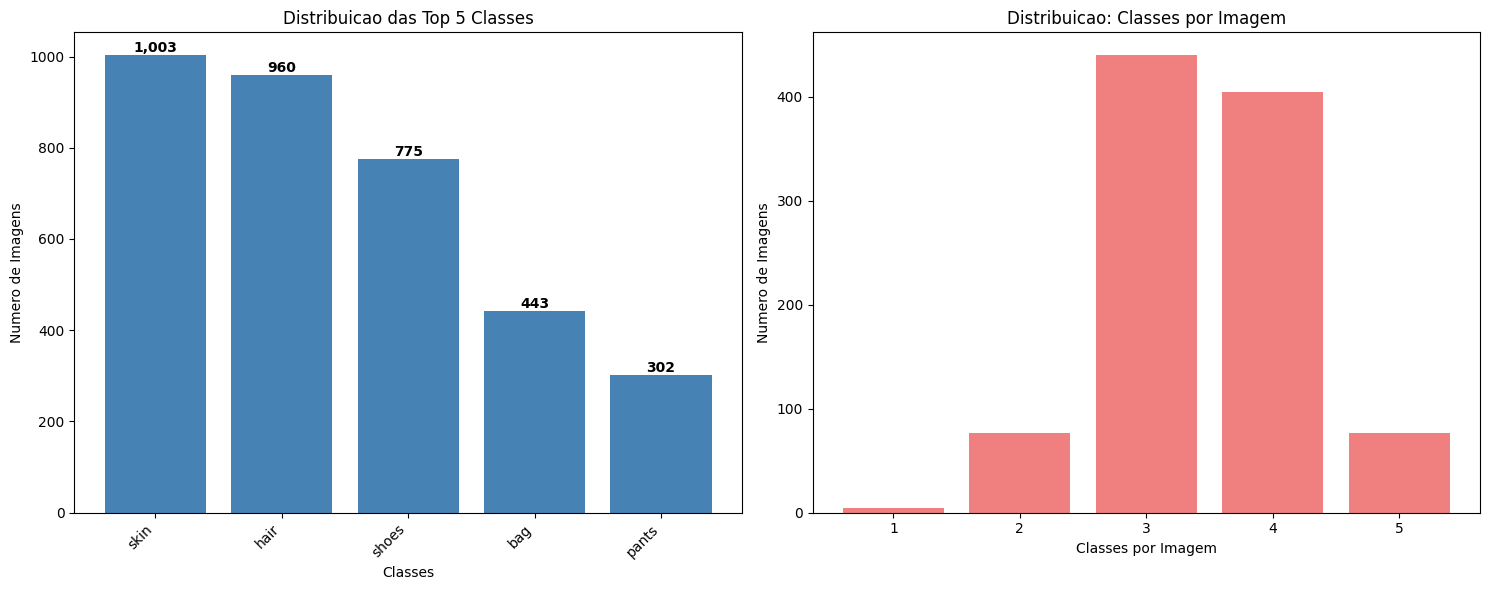

Graficos gerados com sucesso!


In [129]:
print(f"\n MODULO 11: Preparacao final para treinamento")
print("=" * 45)

import json
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

def filtrar_top_5_classes():
    """
    Filtra o dataset para manter apenas as 5 maiores classes

    Returns:
        DataFrame filtrado com apenas as top 5 classes
    """
    if df is None or len(df) == 0:
        print("ERRO: Dataset nao disponivel")
        return None

    print(f"\n[PASSO 1] Identificando as 5 maiores classes...")

    # Contar todas as classes
    todas_classes = []
    for classes_list in df['classes']:
        todas_classes.extend(classes_list)

    contador = Counter(todas_classes)
    top_5_classes = [classe for classe, count in contador.most_common(5)]

    print(f"Top 5 classes selecionadas:")
    for i, (classe, freq) in enumerate(contador.most_common(5), 1):
        pct = freq / len(df) * 100
        print(f"  {i}. {classe}: {freq:,} imagens ({pct:.1f}%)")

    # Filtrar dataset
    print(f"\nFiltrando dataset...")
    def tem_classe_top5(classes_list):
        return any(classe in top_5_classes for classe in classes_list)

    df_filtrado = df[df['classes'].apply(tem_classe_top5)].copy()

    # Manter apenas as top 5 classes
    def filtrar_classes_top5(classes_list):
        return [classe for classe in classes_list if classe in top_5_classes]

    df_filtrado['classes'] = df_filtrado['classes'].apply(filtrar_classes_top5)
    df_filtrado['num_classes'] = df_filtrado['classes'].apply(len)
    df_filtrado = df_filtrado[df_filtrado['num_classes'] > 0].reset_index(drop=True)

    print(f"Resultado:")
    print(f"  Original: {len(df):,} imagens")
    print(f"  Filtrado: {len(df_filtrado):,} imagens")
    print(f"  Reducao: {(1 - len(df_filtrado)/len(df))*100:.1f}%")

    return df_filtrado, top_5_classes

def preparar_labels_binarios(df_filtrado, top_5_classes):
    """
    Prepara labels binarios para cada uma das top 5 classes
    """
    print(f"\n[PASSO 2] Criando labels binarios...")

    df_ml = df_filtrado.copy()

    # Criar colunas binarias para cada classe
    for i, classe in enumerate(top_5_classes, 1):
        nome_coluna = f"label_{classe.replace(' ', '_').replace('/', '_')}"
        df_ml[nome_coluna] = df_ml['classes'].apply(lambda x: 1 if classe in x else 0)

        count_positivos = df_ml[nome_coluna].sum()
        pct_positivos = count_positivos / len(df_ml) * 100
        print(f"  {i}. {classe}: {count_positivos:,} positivos ({pct_positivos:.1f}%)")

    # Estatistica rapida
    df_ml['total_labels'] = df_ml[[f"label_{c.replace(' ', '_').replace('/', '_')}" for c in top_5_classes]].sum(axis=1)
    print(f"\nMedia de labels por imagem: {df_ml['total_labels'].mean():.2f}")

    return df_ml

def salvar_dataset_ml_final(df_ml, top_5_classes, split_train=0.7, split_val=0.15, split_test=0.15):
    """
    Salva dataset final dividido para treinamento de ML
    """
    print(f"\n[PASSO 3] Dividindo dataset ({split_train*100:.0f}%/{split_val*100:.0f}%/{split_test*100:.0f}%)...")

    # Estratificar por classe principal
    def classe_principal(classes_list):
        for classe in top_5_classes:
            if classe in classes_list:
                return classe
        return 'other'

    df_ml['classe_principal'] = df_ml['classes'].apply(classe_principal)

    # Divisao estratificada
    df_train, df_temp = train_test_split(
        df_ml, test_size=(split_val + split_test),
        stratify=df_ml['classe_principal'], random_state=42
    )

    test_size_adjusted = split_test / (split_val + split_test)
    df_val, df_test = train_test_split(
        df_temp, test_size=test_size_adjusted,
        stratify=df_temp['classe_principal'], random_state=42
    )

    print(f"Splits criados:")
    print(f"  Treino:    {len(df_train):,} imagens")
    print(f"  Validacao: {len(df_val):,} imagens")
    print(f"  Teste:     {len(df_test):,} imagens")

    # Preparar colunas finais
    colunas_labels = [f"label_{classe.replace(' ', '_').replace('/', '_')}" for classe in top_5_classes]
    colunas_finais = [
        'image_id', 'image_path_relative', 'label_path_relative',
        'classes', 'num_classes'
    ] + colunas_labels

    # Salvar arquivos
    splits = {'train': df_train, 'validation': df_val, 'test': df_test}

    print(f"\nSalvando arquivos:")
    for split_name, split_df in splits.items():
        df_split_final = split_df[colunas_finais].copy()
        path = os.path.join(BASE_DIR, f"dataset_ml_{split_name}.csv")
        df_split_final.to_csv(path, index=False)
        print(f"  {split_name}: {os.path.basename(path)}")

    # Salvar metadados
    metadados = {
        'dataset_info': {
            'total_images': len(df_ml),
            'top_5_classes': top_5_classes,
            'label_columns': colunas_labels
        },
        'splits': {
            split_name: {'size': len(split_df)}
            for split_name, split_df in splits.items()
        }
    }

    metadata_path = os.path.join(BASE_DIR, "dataset_ml_metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadados, f, indent=2, ensure_ascii=False)
    print(f"  metadados: {os.path.basename(metadata_path)}")

    return df_train, df_val, df_test

def processar_dataset_final():
    """
    Funcao principal que executa todo o processamento final
    """
    print(f"\n")
    print("=" * 50)
    print(f"  PROCESSAMENTO FINAL - TOP 5 CLASSES")
    print("=" * 50)

    # Passo 1: Filtrar top 5 classes
    result = filtrar_top_5_classes()
    if result is None:
        return None

    df_filtrado, top_5_classes = result

    # Passo 2: Preparar labels binarios
    df_ml = preparar_labels_binarios(df_filtrado, top_5_classes)

    # Passo 3: Salvar dataset dividido
    df_train, df_val, df_test = salvar_dataset_ml_final(df_ml, top_5_classes)

    # Relatorio final simples
    print(f"\n")
    print("=" * 50)
    print(f"              DATASET PRONTO!")
    print("=" * 50)
    print(f"Dataset original:  {len(df):,} imagens")
    print(f"Dataset final:     {len(df_ml):,} imagens")
    print(f"Reducao aplicada:  {(1-len(df_ml)/len(df))*100:.1f}%")
    print(f"\nClasses selecionadas: {len(top_5_classes)}")
    for i, classe in enumerate(top_5_classes, 1):
        print(f"  {i}. {classe}")

    print(f"\nArquivos gerados:")
    print(f"  - dataset_ml_train.csv")
    print(f"  - dataset_ml_validation.csv")
    print(f"  - dataset_ml_test.csv")
    print(f"  - dataset_ml_metadata.json")
    print("=" * 50)

    return df_ml, top_5_classes

def visualizar_distribuicao_final(df_ml, top_5_classes):
    """
    Visualiza a distribuicao final das classes
    """
    if df_ml is None or top_5_classes is None:
        print("ERRO: Dados nao disponiveis")
        return

    print(f"\nVisualizando distribuicao das classes...")

    # Preparar dados
    classes_counts = []
    for classe in top_5_classes:
        col_label = f"label_{classe.replace(' ', '_').replace('/', '_')}"
        count = df_ml[col_label].sum()
        classes_counts.append(count)

    # Criar visualizacao
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Grafico 1: Distribuicao por classe
    classes_short = [c[:15] + '...' if len(c) > 15 else c for c in top_5_classes]
    bars = ax1.bar(range(len(top_5_classes)), classes_counts, color='steelblue')
    ax1.set_xlabel('Classes')
    ax1.set_ylabel('Numero de Imagens')
    ax1.set_title('Distribuicao das Top 5 Classes')
    ax1.set_xticks(range(len(top_5_classes)))
    ax1.set_xticklabels(classes_short, rotation=45, ha='right')

    # Adicionar valores
    for bar, count in zip(bars, classes_counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}', ha='center', va='bottom', fontweight='bold')

    # Grafico 2: Classes por imagem
    num_classes_dist = df_ml['num_classes'].value_counts().sort_index()
    ax2.bar(num_classes_dist.index, num_classes_dist.values, color='lightcoral')
    ax2.set_xlabel('Classes por Imagem')
    ax2.set_ylabel('Numero de Imagens')
    ax2.set_title('Distribuicao: Classes por Imagem')

    plt.tight_layout()
    plt.show()

    print(f"Graficos gerados com sucesso!")

print(f"\nFuncoes definidas:")
print(f"  - processar_dataset_final()  [PRINCIPAL]")
print(f"  - visualizar_distribuicao_final()")

print(f"\nExecutando processamento automaticamente...")
print("*" * 50)

# Executar processamento automatico
try:
    df_ml, top_5_classes = processar_dataset_final()

    if df_ml is not None and top_5_classes is not None:
        print(f"\n[BONUS] Gerando visualizacao...")
        visualizar_distribuicao_final(df_ml, top_5_classes)

except Exception as e:
    print(f"ERRO durante processamento: {e}")
    print(f"Verifique se o DataFrame 'df' esta disponivel")

#MODULO 12: Exportar dataset para Google Drive

In [130]:
print(f"\n MODULO 12: Exportar dataset para Google Drive")
print("=" * 50)

import os
import shutil
from datetime import datetime
import zipfile

# Montar Google Drive (se nao estiver montado)
def montar_drive():
    """
    Monta o Google Drive no Colab
    """
    try:
        from google.colab import drive
        print("Montando Google Drive...")
        drive.mount('/content/drive')
        print(" Google Drive montado com sucesso!")
        return True
    except Exception as e:
        print(f" Erro ao montar Drive: {e}")
        return False

def criar_pasta_dataset_drive(nome_projeto="dataset_ml"):
    """
    Cria pasta no Drive para o dataset
    """
    try:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M")
        pasta_nome = f"{nome_projeto}_{timestamp}"

        # Caminho da pasta no Drive
        drive_path = f"/content/drive/MyDrive/{pasta_nome}"

        if not os.path.exists(drive_path):
            os.makedirs(drive_path)
            print(f"Pasta criada: {pasta_nome}")
        else:
            print(f"Pasta ja existe: {pasta_nome}")

        return drive_path, pasta_nome
    except Exception as e:
        print(f"Erro ao criar pasta: {e}")
        return None, None

def copiar_arquivos_dataset(drive_path):
    """
    Copia arquivos do dataset para o Drive
    """
    print(f"\nCopiando arquivos para o Drive...")

    # Lista de arquivos para copiar
    arquivos_dataset = [
        "dataset_ml_train.csv",
        "dataset_ml_validation.csv",
        "dataset_ml_test.csv",
        "dataset_ml_metadata.json"
    ]

    arquivos_copiados = []
    arquivos_nao_encontrados = []

    for arquivo in arquivos_dataset:
        origem = os.path.join(BASE_DIR, arquivo)
        destino = os.path.join(drive_path, arquivo)

        if os.path.exists(origem):
            try:
                shutil.copy2(origem, destino)
                tamanho = os.path.getsize(destino) / (1024 * 1024)  # MB
                arquivos_copiados.append((arquivo, tamanho))
                print(f"  {arquivo} ({tamanho:.2f} MB)")
            except Exception as e:
                print(f"  Erro ao copiar {arquivo}: {e}")
        else:
            arquivos_nao_encontrados.append(arquivo)
            print(f"  Arquivo nao encontrado: {arquivo}")

    return arquivos_copiados, arquivos_nao_encontrados

def criar_zip_dataset(drive_path, nome_pasta):
    """
    Cria arquivo ZIP com o dataset
    """
    print(f"\nCriando arquivo ZIP...")

    zip_path = os.path.join(drive_path, f"{nome_pasta}.zip")

    try:
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            # Adicionar arquivos CSV e JSON
            for arquivo in os.listdir(drive_path):
                if arquivo.endswith(('.csv', '.json')):
                    arquivo_path = os.path.join(drive_path, arquivo)
                    zipf.write(arquivo_path, arquivo)

        # Verificar tamanho do ZIP
        tamanho_zip = os.path.getsize(zip_path) / (1024 * 1024)  # MB
        print(f" ZIP criado: {nome_pasta}.zip ({tamanho_zip:.2f} MB)")

        return zip_path, tamanho_zip
    except Exception as e:
        print(f" Erro ao criar ZIP: {e}")
        return None, 0

def criar_readme_dataset(drive_path, top_5_classes, df_ml):
    """
    Cria arquivo README com informacoes do dataset
    """
    print(f"\nCriando README...")

    readme_content = f"""# Dataset ML - Segmentacao Multi-label

## Informacoes Gerais
- **Data de criacao**: {datetime.now().strftime('%d/%m/%Y %H:%M')}
- **Total de imagens**: {len(df_ml):,}
- **Numero de classes**: {len(top_5_classes)}
- **Tipo de problema**: Multi-label Image Segmentation

## Classes Selecionadas (Top 5)
"""

    for i, classe in enumerate(top_5_classes, 1):
        col_label = f"label_{classe.replace(' ', '_').replace('/', '_')}"
        count = df_ml[col_label].sum()
        pct = count / len(df_ml) * 100
        readme_content += f"{i}. **{classe}**: {count:,} imagens ({pct:.1f}%)\n"

    readme_content += f"""
## Estrutura dos Arquivos

### Arquivos CSV:
- `dataset_ml_train.csv`: Dados de treinamento (70%)
- `dataset_ml_validation.csv`: Dados de validacao (15%)
- `dataset_ml_test.csv`: Dados de teste (15%)
- `dataset_ml_metadata.json`: Metadados completos

### Colunas dos CSVs:
- `image_id`: ID unico da imagem
- `image_path_relative`: Caminho relativo da imagem
- `label_path_relative`: Caminho relativo da mascara
- `classes`: Lista das classes presentes na imagem
- `num_classes`: Numero de classes na imagem
- `label_[classe]`: Colunas binarias (0/1) para cada classe

## Estatisticas do Dataset
- **Media de classes por imagem**: {df_ml['total_labels'].mean():.2f}
- **Distribuicao por splits**:
  - Treinamento: ~70% das imagens
  - Validacao: ~15% das imagens
  - Teste: ~15% das imagens

## Como Usar

```python
import pandas as pd

# Carregar dados
train_df = pd.read_csv('dataset_ml_train.csv')
val_df = pd.read_csv('dataset_ml_validation.csv')
test_df = pd.read_csv('dataset_ml_test.csv')

# Colunas de labels binarios
label_columns = [col for col in train_df.columns if col.startswith('label_')]
print(f"Labels disponiveis: {{label_columns}}")
```

## Recomendacoes para Treinamento
- **Arquiteturas**: U-Net, DeepLabV3+, Mask R-CNN
- **Loss Function**: Binary Cross Entropy (por classe)
- **Metricas**: IoU, Dice Score, mAP
- **Data Augmentation**: Rotation, Flip, Scale, Color Jitter

---
*Dataset processado automaticamente via pipeline de Machine Learning*
"""

    readme_path = os.path.join(drive_path, "README.md")

    try:
        with open(readme_path, 'w', encoding='utf-8') as f:
            f.write(readme_content)
        print(f" README.md criado")
        return readme_path
    except Exception as e:
        print(f" Erro ao criar README: {e}")
        return None

def exportar_dataset_completo(nome_projeto="dataset_ml"):
    """
    Funcao principal para exportar todo o dataset para o Drive
    """
    print(f"\n")
    print("=" * 60)
    print(f"         EXPORTANDO DATASET PARA GOOGLE DRIVE")
    print("=" * 60)

    # Verificar se os dados estao disponiveis
    if 'df_ml' not in globals() or 'top_5_classes' not in globals():
        print(" ERRO: Dataset nao foi processado ainda!")
        print("Execute primeiro: processar_dataset_final()")
        return False

    # Passo 1: Montar Drive
    if not montar_drive():
        return False

    # Passo 2: Criar pasta
    drive_path, pasta_nome = criar_pasta_dataset_drive(nome_projeto)
    if not drive_path:
        return False

    # Passo 3: Copiar arquivos
    arquivos_copiados, arquivos_nao_encontrados = copiar_arquivos_dataset(drive_path)

    # Passo 4: Criar README
    readme_path = criar_readme_dataset(drive_path, top_5_classes, df_ml)

    # Passo 5: Criar ZIP
    zip_path, tamanho_zip = criar_zip_dataset(drive_path, pasta_nome)

    # Relatorio final
    print(f"\n")
    print("=" * 60)
    print(f"                 EXPORT CONCLUIDO!")
    print("=" * 60)
    print(f" Pasta no Drive: {pasta_nome}")
    print(f" Caminho completo: /content/drive/MyDrive/{pasta_nome}")
    print(f"")
    print(f" Arquivos exportados:")
    for arquivo, tamanho in arquivos_copiados:
        print(f" {arquivo} ({tamanho:.2f} MB)")

    if readme_path:
        print(f" README.md")

    if zip_path:
        print(f" {pasta_nome}.zip ({tamanho_zip:.2f} MB)")

    if arquivos_nao_encontrados:
        print(f"\n Arquivos nao encontrados:")
        for arquivo in arquivos_nao_encontrados:
            print(f"  - {arquivo}")

    print(f"\n Dataset pronto para download do Google Drive!")
    print("=" * 60)

    return True

def listar_arquivos_drive():
    """
    Lista pastas do dataset no Drive
    """
    try:
        drive_root = "/content/drive/MyDrive"
        pastas_dataset = []

        if os.path.exists(drive_root):
            for item in os.listdir(drive_root):
                if item.startswith("dataset_ml_"):
                    pasta_path = os.path.join(drive_root, item)
                    if os.path.isdir(pasta_path):
                        # Contar arquivos na pasta
                        arquivos = [f for f in os.listdir(pasta_path) if f.endswith(('.csv', '.json', '.zip', '.md'))]
                        pastas_dataset.append((item, len(arquivos)))

        if pastas_dataset:
            print(f"\nPastas de dataset encontradas no Drive:")
            for pasta, n_arquivos in pastas_dataset:
                print(f" {pasta} ({n_arquivos} arquivos)")
        else:
            print(f"\nNenhuma pasta de dataset encontrada no Drive")

        return pastas_dataset
    except Exception as e:
        print(f" Erro ao listar pastas: {e}")
        return []

print(f"\nFuncoes definidas:")
# Executar exportacao automatica
try:
    sucesso = exportar_dataset_completo()

    if sucesso:
        print(f"\n[BONUS] Listando arquivos no Drive...")
        listar_arquivos_drive()

except Exception as e:
    print(f" Erro durante exportacao: {e}")


 MODULO 12: Exportar dataset para Google Drive

Funcoes de exportacao definidas:
  - exportar_dataset_completo()  [PRINCIPAL]
  - listar_arquivos_drive()

Executando exportacao automaticamente...
**************************************************


         EXPORTANDO DATASET PARA GOOGLE DRIVE
Montando Google Drive...
Mounted at /content/drive
 Google Drive montado com sucesso!
Pasta criada: dataset_ml_20250922_2244

Copiando arquivos para o Drive...
  dataset_ml_train.csv (0.07 MB)
  dataset_ml_validation.csv (0.02 MB)
  dataset_ml_test.csv (0.02 MB)
  dataset_ml_metadata.json (0.00 MB)

Criando README...
 README.md criado

Criando arquivo ZIP...
 ZIP criado: dataset_ml_20250922_2244.zip (0.01 MB)


                 EXPORT CONCLUIDO!
 Pasta no Drive: dataset_ml_20250922_2244
 Caminho completo: /content/drive/MyDrive/dataset_ml_20250922_2244

 Arquivos exportados:
 dataset_ml_train.csv (0.07 MB)
 dataset_ml_validation.csv (0.02 MB)
 dataset_ml_test.csv (0.02 MB)
 dataset_ml_metadata.j